Diagrams are designed by: **https://www.plantuml.com.**

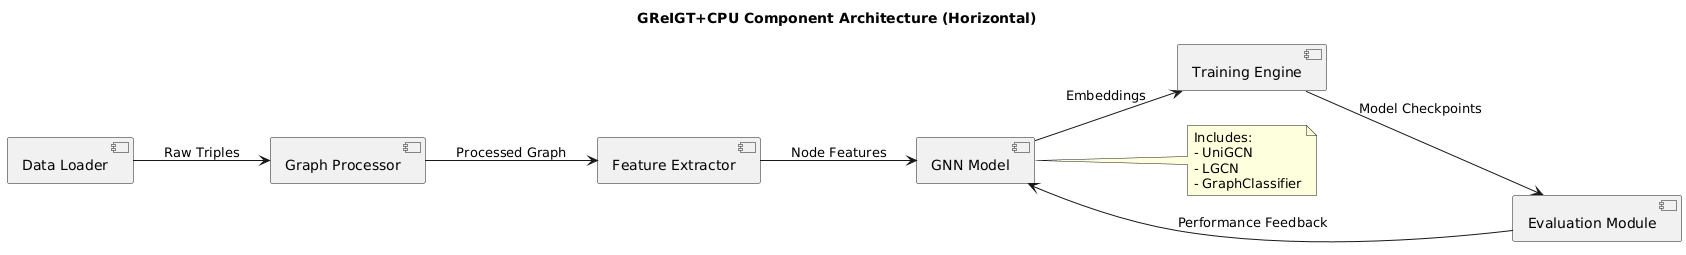

This diagram outlines the GReIGT+CPU component architecture. The flow begins with the Data Loader (DL) for loading raw triples, followed by the Graph Processor (GP) for graph creation. The Feature Extractor (FE) extracts node features, which are then processed by the GNN Model (GNN) to produce embeddings. The Training Engine (TE) trains the model and saves checkpoints, while the Evaluation Module (EM) evaluates the model and provides performance feedback back to the GNN. Key GNN components include UniGCN, LGCN, and GraphClassifier.

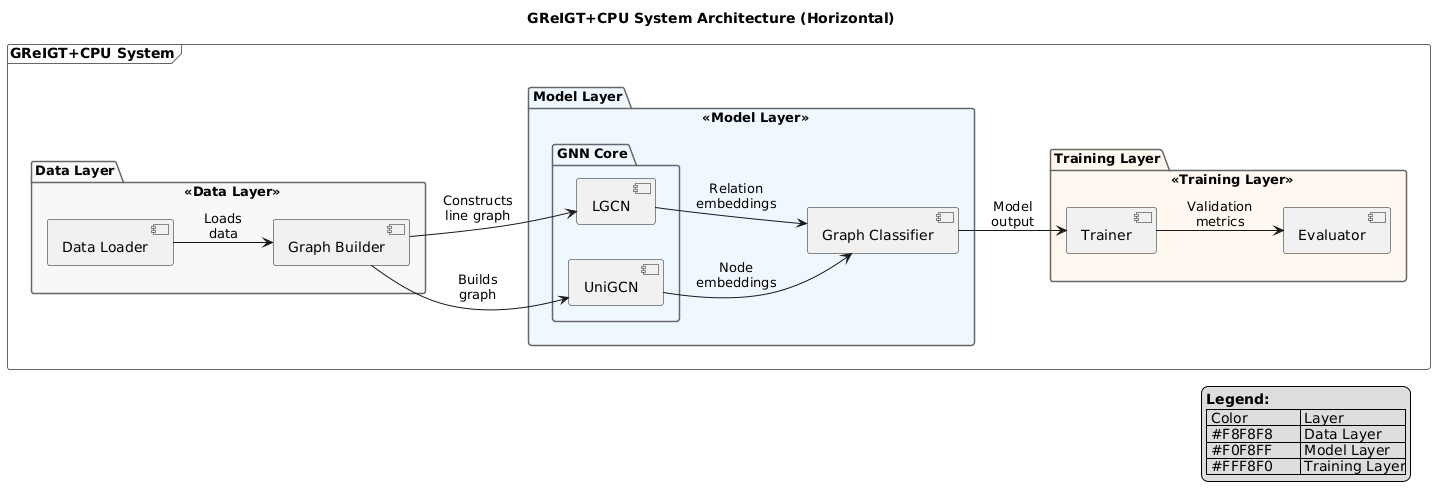

This package diagram illustrates the **GReIGT+CPU System Architecture** organized horizontally into three layers:

1. **Data Layer:** Responsible for loading and constructing graphs.
   - **Data Loader (DL):** Loads raw data.
   - **Graph Builder (GB):** Builds processed graphs and constructs line graphs for modeling.

2. **Model Layer:** Processes data with graph-based models.
   - **GNN Core:** Includes models like **UniGCN** for node embeddings and **LGCN** for relation embeddings.
   - **Graph Classifier (GC):** Combines embeddings to generate classification outputs.

3. **Training Layer:** Handles training and evaluation.
   - **Trainer (TR):** Trains the model using outputs from the classifier.
   - **Evaluator (EV):** Provides validation metrics to refine the model.



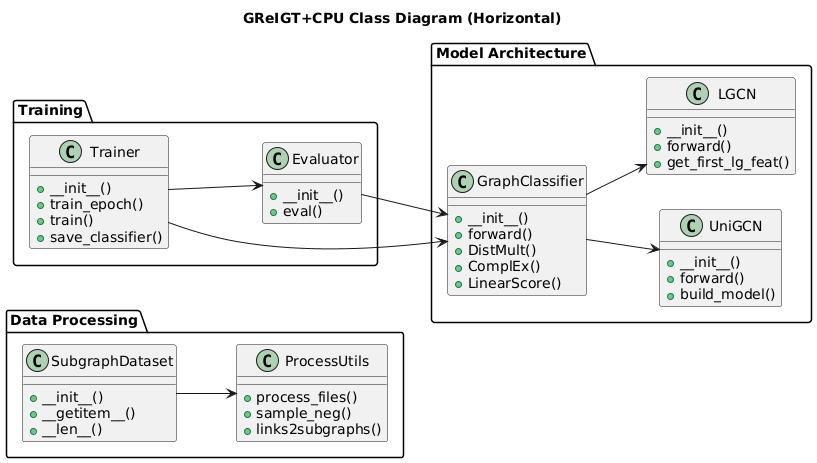

This **GReIGT+CPU Class Diagram** organizes the system into three logical packages:

1. **Data Processing:**
   - **SubgraphDataset:** Manages datasets and provides methods for initialization (`__init__()`), accessing items (`__getitem__()`), and determining the dataset's length (`__len__()`).
   - **ProcessUtils:** Contains utility functions such as `process_files()` for handling data, `sample_neg()` for negative sampling, and `links2subgraphs()` for creating subgraphs.

2. **Model Architecture:**
   - **GraphClassifier:** Implements methods for graph classification, including scoring techniques like `DistMult()`, `ComplEx()`, and `LinearScore()`, as well as processing through `forward()` for embedding generation.
   - **UniGCN:** Specializes in building a graph neural network (GNN) model using `build_model()` and provides forward processing.
   - **LGCN:** Focuses on features of line graphs, offering methods like `get_first_lg_feat()` for extracting initial line graph features.

3. **Training:**
   - **Trainer:** Handles training operations through methods like `train_epoch()`, `train()`, and saving classifiers with `save_classifier()`.
   - **Evaluator:** Provides evaluation functionalities to assess the performance of trained models via `eval()`.

 **Class Interactions:**
- **SubgraphDataset** connects to **ProcessUtils** for dataset processing.
- **GraphClassifier** interacts with both **UniGCN** and **LGCN** to incorporate node and relation embeddings.
- **Trainer** collaborates with **GraphClassifier** for training and **Evaluator** for validation, while **Evaluator** directly assesses the classifier's output.


**Install Library And Setting Up the Environment**

In [ ]:
# https://pytorch.org/get-started/previous-versions/
# https://www.dgl.ai/pages/start.html
# https://github.com/dmlc/dgl/blob/master/docker/README.md

# CUDA 12.4
!pip install torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cu124 > /dev/null
!pip install --pre dgl -f https://data.dgl.ai/wheels-test/torch-2.4/cu124/repo.html > /dev/null
!pip install lmdb > /dev/null
!pip install tqdm > /dev/null
!pip install jdatetime > /dev/null

import os
os.environ['DGLBACKEND'] = 'pytorch'

**Check Library Version**

In [ ]:
import sklearn
import networkx
import torch
import tqdm
import lmdb
import dgl
import numpy as np

print('numpy: ', np.__version__)
print('sklearn: ' , sklearn.__version__)
print('networkx: ', networkx.__version__)
print('torch: ', torch.__version__)
print('tqdm:', tqdm.__version__)
print('lmdb:', lmdb.__version__)
print('dgl:', dgl.__version__)
!nvcc --version

numpy:  2.0.2
sklearn:  1.6.1
networkx:  3.4.2
torch:  2.4.0+cu124
tqdm: 4.67.1
lmdb: 1.6.2
dgl: 2.5a241215+cu124
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


**LogFile_Utiles**

In [ ]:
import jdatetime
from datetime import datetime
import pytz

def write_log(file_path, message, timezone_str='Asia/Tehran'):
    try:
        timezone = pytz.timezone(timezone_str)
        now_utc = datetime.now(tz=timezone)
        now_jalali = jdatetime.datetime.fromgregorian(datetime=now_utc)
        with open(file_path, 'a') as file:
            file.write(f'{now_jalali.strftime("%Y-%m-%d %H:%M:%S")} - {message}\n')

    except Exception as e:
        print(f"خطا در ثبت لاگ: {e}")

# مسیر فایل لاگ
log_file_path = '/content/experiment/log.txt'
write_log(log_file_path, "ایجاد فایل لاگ.")
write_log(log_file_path, "پیام نمونه برای تست و بررسی.")

**Save_Utiles**

In [ ]:
import pickle

def serialize(data):
    data_tuple = tuple(data.values())
    return pickle.dumps(data_tuple)


def deserialize(data):
    data_tuple = pickle.loads(data)
    keys = ('nodes', 'r_label', 'g_label', 'n_label')
    return dict(zip(keys, data_tuple))

**Process_Utiles**

In [ ]:
import numpy as np
from scipy.sparse import csc_matrix
import json
import logging
from tqdm import tqdm  # یا import tqdm

def process_files(files, saved_relation2id=None):

    entity2id = {}
    relation2id = {} if saved_relation2id is None else saved_relation2id
    triplets = {}

    ent = 0
    rel = 0

    for file_type, file_path in files.items():  # file_type: train, valid, test

        data = []
        with open(file_path) as f:
            file_data = [line.split() for line in f.read().split('\n')[:-1]]

        for triplet in file_data:
            if triplet[0] not in entity2id:
                entity2id[triplet[0]] = ent
                ent += 1
            if triplet[2] not in entity2id:
                entity2id[triplet[2]] = ent
                ent += 1
            if not saved_relation2id and triplet[1] not in relation2id:
                relation2id[triplet[1]] = rel
                rel += 1

            # Save the triplets corresponding to only the known relations
            if triplet[1] in relation2id:
                data.append([entity2id[triplet[0]], entity2id[triplet[2]], relation2id[triplet[1]]])  # (h, t, r)

        triplets[file_type] = np.array(data)

    id2entity = {v: k for k, v in entity2id.items()}
    id2relation = {v: k for k, v in relation2id.items()}

    adj_list = []
    for i in range(len(relation2id)):
        idx = np.argwhere(triplets['train'][:, 2] == i)
        adj_list.append(csc_matrix((np.ones(len(idx), dtype=np.uint8), (triplets['train'][:, 0][idx].squeeze(1), triplets['train'][:, 1][idx].squeeze(1))), shape=(len(entity2id), len(entity2id))))

    return adj_list, triplets, entity2id, relation2id, id2entity, id2relation

def sample_neg(adj_list, edges, num_neg_samples_per_link=1, max_size=1000000, constrained_neg_prob=0):
    pos_edges = edges
    neg_edges = []

    # if max_size is set, randomly sample train links
    if max_size < len(pos_edges):
        perm = np.random.permutation(len(pos_edges))[:max_size]
        pos_edges = pos_edges[perm]

    # sample negative links for train/test
    n, r = adj_list[0].shape[0], len(adj_list)

    # possible head and tails for each relation
    valid_heads = [adj.tocoo().row.tolist() for adj in adj_list]
    valid_tails = [adj.tocoo().col.tolist() for adj in adj_list]

    # پیکربندی tqdm به عنوان یک تابع
    pbar = tqdm(total=len(pos_edges) * num_neg_samples_per_link)
    while len(neg_edges) < num_neg_samples_per_link * len(pos_edges):
        neg_head, neg_tail, rel = pos_edges[pbar.n % len(pos_edges)][0], pos_edges[pbar.n % len(pos_edges)][1], \
                                  pos_edges[pbar.n % len(pos_edges)][2]
        if np.random.uniform() < constrained_neg_prob:
            if np.random.uniform() < 0.5:
                neg_head = np.random.choice(valid_heads[rel])
            else:
                neg_tail = np.random.choice(valid_tails[rel])
        else:
            if np.random.uniform() < 0.5:
                neg_head = np.random.choice(n)
            else:
                neg_tail = np.random.choice(n)

        if neg_head != neg_tail and adj_list[rel][neg_head, neg_tail] == 0:
            neg_edges.append([neg_head, neg_tail, rel])
            pbar.update(1)

    pbar.close()

    neg_edges = np.array(neg_edges)
    return pos_edges, neg_edges

def intialize_worker(A, params, max_label_value):
    global A_, params_, max_label_value_
    A_, params_, max_label_value_ = A, params, max_label_value

def extract_save_subgraph(A_, params_, max_label_value_, args_):
# def extract_save_subgraph(args_):
    idx, (n1, n2, r_label), g_label = args_
    nodes, n_labels, subgraph_size, enc_ratio, num_pruned_nodes = subgraph_extraction_labeling((n1, n2),
                                                                                               r_label,
                                                                                               A_,
                                                                                               params_.max_nodes_per_hop)

    if max_label_value_ is not None:
        n_labels = np.array([np.minimum(label, max_label_value_).tolist() for label in n_labels])

    datum = {'nodes': nodes,
             'r_label': r_label,
             'g_label': g_label,
             'n_labels': n_labels,
             'subgraph_size': subgraph_size,
             'enc_ratio': enc_ratio,
             'num_pruned_nodes': num_pruned_nodes}

    str_id = '{:08}'.format(idx).encode('ascii')
    return (str_id, datum)

def links2subgraphs(adj_list, graphs, params, max_label_value=None):
    A = adj_list
    max_n_label = {'value': np.array([0, 0])}
    subgraph_sizes = []
    enc_ratios = []
    num_pruned_nodes = []

    # محاسبه اندازه اولیه نقشه
    BYTES_PER_DATUM = get_average_subgraph_size(100, list(graphs.values())[0]['pos'], A, params) * 1.5
    links_length = 0
    for split_name, split in graphs.items():
        links_length += (len(split['pos']) + len(split['neg'])) * 2
    map_size = max(int(links_length * BYTES_PER_DATUM * 100), 10**9)  # حداقل 1 گیگابایت

    # ایجاد محیط LMDB با اندازه نقشه مناسب
    env = lmdb.open(params.db_path, max_dbs=6, map_size=map_size)

    def extraction_helper(split_env, A, params, max_label_value, links, g_labels):
        max_n_label = {'value': np.array([0, 0])}
        subgraph_sizes = []
        enc_ratios = []
        num_pruned_nodes = []

        # تعداد گراف‌ها در پایگاه داده ثبت می‌شود
        with env.begin(write=True, db=split_env) as txn:
            txn.put('num_graphs'.encode(), (len(links)).to_bytes(int.bit_length(len(links)), byteorder='little'))

        args_ = zip(range(len(links)), links, g_labels)
        params.max_nodes_per_hop = 1

        for arg in tqdm(args_, total=len(links)):
            str_id, datum = extract_save_subgraph(A, params, max_label_value, arg)
            max_n_label['value'] = np.maximum(np.max(datum['n_labels'], axis=0), max_n_label['value'])
            subgraph_sizes.append(datum['subgraph_size'])
            enc_ratios.append(datum['enc_ratio'])
            num_pruned_nodes.append(datum['num_pruned_nodes'])

            # ذخیره داده‌ها در LMDB
            with env.begin(write=True, db=split_env) as txn:
                txn.put(str_id, serialize(datum))

        return max_n_label, subgraph_sizes, enc_ratios, num_pruned_nodes

    for split_name, split in graphs.items():
        logging.info(f"Extracting enclosing subgraphs for positive links in {split_name} set")
        log_file_path = '/content/experiment/log.txt'
        write_log(log_file_path, f'Extracting enclosing subgraphs for positive links in {split_name} set')

        # پردازش لینک‌های مثبت
        labels = np.ones(len(split['pos']))
        db_name_pos = split_name + '_pos'
        split_env = env.open_db(db_name_pos.encode())
        links = split['pos']
        g_labels = np.ones(len(split['pos']))
        max_n_label, subgraph_sizes, enc_ratios, num_pruned_nodes = extraction_helper(split_env,
                                                                                      A,
                                                                                      params,
                                                                                      max_label_value,
                                                                                      split['pos'],
                                                                                      g_labels)

        logging.info(f"Extracting enclosing subgraphs for negative links in {split_name} set")
        write_log(log_file_path, f'Extracting enclosing subgraphs for negative links in {split_name} set')

        # پردازش لینک‌های منفی
        labels = np.zeros(len(split['neg']))
        db_name_neg = split_name + '_neg'
        split_env = env.open_db(db_name_neg.encode())
        g_labels = np.ones(len(split['neg']))
        max_n_label, subgraph_sizes, enc_ratios, num_pruned_nodes = extraction_helper(split_env,
                                                                                      A,
                                                                                      params,
                                                                                      max_label_value,
                                                                                      split['neg'], g_labels)

    # ذخیره اطلاعات نهایی در LMDB
    max_n_label['value'] = max_label_value if max_label_value is not None else max_n_label['value']
    with env.begin(write=True) as txn:
        bit_len_label_sub = int.bit_length(int(max_n_label['value'][0]))
        bit_len_label_obj = int.bit_length(int(max_n_label['value'][1]))
        txn.put('max_n_label_sub'.encode(),
                (int(max_n_label['value'][0])).to_bytes(bit_len_label_sub, byteorder='little'))
        txn.put('max_n_label_obj'.encode(),
                (int(max_n_label['value'][1])).to_bytes(bit_len_label_obj, byteorder='little'))

        txn.put('avg_subgraph_size'.encode(), struct.pack('f', float(np.mean(subgraph_sizes))))
        txn.put('min_subgraph_size'.encode(), struct.pack('f', float(np.min(subgraph_sizes))))
        txn.put('max_subgraph_size'.encode(), struct.pack('f', float(np.max(subgraph_sizes))))
        txn.put('std_subgraph_size'.encode(), struct.pack('f', float(np.std(subgraph_sizes))))

        txn.put('avg_enc_ratio'.encode(), struct.pack('f', float(np.mean(enc_ratios))))
        txn.put('min_enc_ratio'.encode(), struct.pack('f', float(np.min(enc_ratios))))
        txn.put('max_enc_ratio'.encode(), struct.pack('f', float(np.max(enc_ratios))))
        txn.put('std_enc_ratio'.encode(), struct.pack('f', float(np.std(enc_ratios))))

        txn.put('avg_num_pruned_nodes'.encode(), struct.pack('f', float(np.mean(num_pruned_nodes))))
        txn.put('min_num_pruned_nodes'.encode(), struct.pack('f', float(np.min(num_pruned_nodes))))
        txn.put('max_num_pruned_nodes'.encode(), struct.pack('f', float(np.max(num_pruned_nodes))))
        txn.put('std_num_pruned_nodes'.encode(), struct.pack('f', float(np.std(num_pruned_nodes))))

# Generate Subgraph dataset
def generate_subgraph_datasets(params,
                               splits=['train', 'valid'],
                               saved_relation2id=None,
                               max_label_value=None):
    testing = 'test' in splits
    adj_list, triplets, entity2id, relation2id, id2entity, id2relation = process_files(params.file_paths, saved_relation2id)

    data_path = os.path.join(params.main_dir, f'{params.data_dir}/{params.dataset}/relation2id.json')
    if not os.path.isdir(data_path) and not testing:
        with open(data_path, 'w') as f:
            json.dump(relation2id, f)

    graphs = {}
    for split_name in splits:
        graphs[split_name] = {'triplets': triplets[split_name], 'max_size': params.max_links}

    # Sample train and valid/test links
    for split_name, split in graphs.items():
        logging.info(f"Sampling negative links for {split_name}")
        log_file_path = '/content/experiment/log.txt'
        log_message = f'Sampling negative links for {split_name}'
        write_log(log_file_path, log_message)

        # index_ = [item in old_ids for item in split['triplets'][:,2]]  #
        split['pos'], split['neg'] = sample_neg(adj_list,
                                                split['triplets'],
                                                params.num_neg_samples_per_link,
                                                max_size=split['max_size'],
                                                constrained_neg_prob=params.constrained_neg_prob)


    # return adj_list, graphs, params, max_label_value
    links2subgraphs(adj_list,
                    graphs,
                    params,
                    max_label_value)

**Graph_Utiles**

In [ ]:
import numpy as np
import scipy.sparse as ssp
import random
import networkx as nx
import torch
import dgl
import copy
import itertools
from tqdm import tqdm
import logging
import lmdb
import multiprocessing as mp

def _bfs_relational(adj, roots, max_nodes_per_hop=None):

    visited = set()
    current_lvl = set(roots)

    next_lvl = set()

    while current_lvl:

        for v in current_lvl:
            visited.add(v)

        next_lvl = _get_neighbors(adj, current_lvl)
        next_lvl -= visited  # set difference

        if max_nodes_per_hop and max_nodes_per_hop < len(next_lvl):
            next_lvl = set(random.sample(next_lvl, max_nodes_per_hop))

        yield next_lvl

        current_lvl = set.union(next_lvl)


def _get_neighbors(adj, nodes):

    sp_nodes = _sp_row_vec_from_idx_list(list(nodes), adj.shape[1])
    sp_neighbors = sp_nodes.dot(adj)
    neighbors = set(ssp.find(sp_neighbors)[1])  # convert to set of indices
    return neighbors


def _sp_row_vec_from_idx_list(idx_list, dim):
    """Create sparse vector of dimensionality dim from a list of indices."""
    shape = (1, dim)
    data = np.ones(len(idx_list))
    row_ind = np.zeros(len(idx_list))
    col_ind = list(idx_list)
    return ssp.csr_matrix((data, (row_ind, col_ind)), shape=shape)


def get_neighbor_nodes(roots, adj, h=1, max_nodes_per_hop=None):
    bfs_generator = _bfs_relational(adj, roots, max_nodes_per_hop)
    lvls = list()
    for _ in range(h):
        try:
            lvls.append(next(bfs_generator))
        except StopIteration:
            pass
    return set().union(*lvls)


def incidence_matrix(adj_list):
    '''
    adj_list: List of sparse adjacency matrices
    '''

    rows, cols, dats = [], [], []
    dim = adj_list[0].shape
    for adj in adj_list:
        adjcoo = adj.tocoo()
        rows += adjcoo.row.tolist()
        cols += adjcoo.col.tolist()
        dats += adjcoo.data.tolist()
    row = np.array(rows)
    col = np.array(cols)
    data = np.array(dats)
    return ssp.csc_matrix((data, (row, col)), shape=dim)


def get_average_subgraph_size(sample_size, links, A, params):
    total_size = 0
    for (n1, n2, r_label) in links[np.random.choice(len(links), sample_size)]:
        nodes, n_labels, subgraph_size, enc_ratio, num_pruned_nodes = subgraph_extraction_labeling((n1, n2), r_label, A, params.hop, params.enclosing_sub_graph, params.max_nodes_per_hop)
        datum = {
                 'nodes': nodes,
                 'r_label': r_label,
                 'g_label': 0,
                 'n_labels': n_labels,
                 'subgraph_size': subgraph_size,
                 'enc_ratio': enc_ratio,
                 'num_pruned_nodes': num_pruned_nodes
                 }

        total_size += len(serialize(datum))
    return total_size / sample_size


def subgraph_extraction_labeling(ind,
                                 rel,
                                 A_list,
                                 h=1,
                                 enclosing_sub_graph=False,
                                 max_nodes_per_hop=None,
                                 max_node_label_value=None):

    # extract the h-hop enclosing subgraphs around link 'ind'
    A_incidence = incidence_matrix(A_list)
    A_incidence += A_incidence.T

    root1_nei = get_neighbor_nodes(set([ind[0]]), A_incidence, h, max_nodes_per_hop)
    root2_nei = get_neighbor_nodes(set([ind[1]]), A_incidence, h, max_nodes_per_hop)

    subgraph_nei_nodes_int = root1_nei.intersection(root2_nei)
    subgraph_nei_nodes_un = root1_nei.union(root2_nei)

    # Extract subgraph | Roots being in the front is essential for labelling and the model to work properly.
    if enclosing_sub_graph:
        subgraph_nodes = list(ind) + list(subgraph_nei_nodes_int)
    else:
        subgraph_nodes = list(ind) + list(subgraph_nei_nodes_un)

    subgraph = [adj[subgraph_nodes, :][:, subgraph_nodes] for adj in A_list]

    labels, enclosing_subgraph_nodes = node_label(incidence_matrix(subgraph), max_distance=h)

    pruned_subgraph_nodes = np.array(subgraph_nodes)[enclosing_subgraph_nodes].tolist()
    pruned_labels = labels[enclosing_subgraph_nodes]

    if max_node_label_value is not None:
        pruned_labels = np.array([np.minimum(label, max_node_label_value).tolist() for label in pruned_labels])

    subgraph_size = len(pruned_subgraph_nodes)
    enc_ratio = len(subgraph_nei_nodes_int) / (len(subgraph_nei_nodes_un) + 1e-3)
    num_pruned_nodes = len(subgraph_nodes) - len(pruned_subgraph_nodes)

    return pruned_subgraph_nodes, pruned_labels, subgraph_size, enc_ratio, num_pruned_nodes


def node_label(subgraph, max_distance=1):
    roots = [0, 1]  #
    sgs_single_root = [remove_nodes(subgraph, [root]) for root in roots]
    dist_to_roots = [np.clip(ssp.csgraph.dijkstra(sg, indices=[0], directed=False, unweighted=True, limit=1e6)[:, 1:], 0, 1e7) for r, sg in enumerate(sgs_single_root)]
    dist_to_roots = np.array(list(zip(dist_to_roots[0][0], dist_to_roots[1][0])), dtype=int)  #

    target_node_labels = np.array([[0, 1], [1, 0]])  #
    labels = np.concatenate((target_node_labels, dist_to_roots)) if dist_to_roots.size else target_node_labels

    enclosing_subgraph_nodes = np.where(np.max(labels, axis=1) <= max_distance)[0]
    return labels, enclosing_subgraph_nodes


def remove_nodes(A_incidence, nodes):
    idxs_wo_nodes = list(set(range(A_incidence.shape[1])) - set(nodes))
    return A_incidence[idxs_wo_nodes, :][:, idxs_wo_nodes]

def ssp_multigraph_to_dgl(graph, n_feats=None):

    g_nx = nx.MultiDiGraph()
    g_nx.add_nodes_from(list(range(graph[0].shape[0])))
    # Add edges
    for rel, adj in enumerate(graph):
        # Convert adjacency matrix to tuples for nx0
        nx_triplets = []
        for src, dst in list(zip(adj.tocoo().row, adj.tocoo().col)):
            nx_triplets.append((src, dst, {'type': rel}))
        g_nx.add_edges_from(nx_triplets)

    # make dgl graph
    # g_dgl = dgl.DGLGraph(multigraph=True)
    # g_dgl.from_networkx(g_nx, edge_attrs=['type'])
    g_dgl = dgl.from_networkx(g_nx, edge_attrs=['type'])
    # add node features
    if n_feats is not None:
        g_dgl.ndata['feat'] = torch.tensor(n_feats)

    return g_dgl


def ssp_multigraph_to_dgl_new(graph, n_feats=None):

    in_nodes = [[] for i in range(graph[0].shape[0])]
    out_nodes = copy.deepcopy(in_nodes)
    g_nx = nx.MultiDiGraph()
    g_nx.add_nodes_from(list(range(graph[0].shape[0])))
    # Add edges
    e_id = 0
    for rel, adj in enumerate(graph):
        # Convert adjacency matrix to tuples for nx0
        nx_triplets = []
        for src, dst in list(zip(adj.tocoo().row, adj.tocoo().col)):
            nx_triplets.append((src, dst, {'type': rel, 'id': e_id}))
            out_nodes[src].append(e_id)
            in_nodes[dst].append(e_id)
            e_id = e_id + 1
        g_nx.add_edges_from(nx_triplets)

    # g_dgl = dgl.DGLGraph(multigraph=True)
    # g_dgl.from_networkx(g_nx, edge_attrs=['type', 'id'])
    g_dgl = dgl.from_networkx(g_nx, edge_attrs=['type','id'])
    if n_feats is not None:
        g_dgl.ndata['feat'] = torch.tensor(n_feats)

    return g_dgl, in_nodes, out_nodes


def create_line_graph_etype(graph, in_nodes, out_nodes):
    graph.edata["etype"] = torch.tensor([0]*graph.edges()[0].shape[0])
    edge_num = graph.edges()[1].shape[0]
    graph.add_edges(graph.edges()[1], graph.edges()[0], {'etype': torch.tensor([1]*edge_num)})

    _, indices = torch.sort(graph.ndata["id"])


    for nodes in tqdm(out_nodes, total = len(out_nodes)):
        src = []
        dst = []
        for node_pair in itertools.product(nodes, nodes):
                if node_pair[0] != node_pair[1]:
                    src.append(indices[node_pair[0]])
                    dst.append(indices[node_pair[1]])
        if src != [] and dst != []:
            graph.add_edges(src, dst, {'etype': torch.tensor([2]*len(src))})

    for nodes in tqdm(in_nodes, total = len(in_nodes)):
        src = []
        dst = []
        for node_pair in itertools.product(nodes, nodes):
                if node_pair[0] != node_pair[1]:
                    src.append(indices[node_pair[0]])
                    dst.append(indices[node_pair[1]])
        if src != [] and dst != []:
            graph.add_edges(src, dst, {'etype': torch.tensor([3]*len(src))})
    return graph

**Data_Utiles**

In [ ]:
import lmdb
import logging
import struct
import dgl
import numpy as np
import torch
from torch.utils.data import Dataset

class SubgraphDataset(Dataset):

    def __init__(self,
                 db_path,
                 id2revid,
                 db_name_pos,
                 db_name_neg,
                 raw_data_paths,
                 included_relations=None,
                 add_traspose_rels=False,
                 num_neg_samples_per_link=1,
                 use_kge_embeddings=False,
                 dataset='',
                 kge_model='',
                 file_name=''):

        self.main_env = lmdb.open(db_path, readonly=True, max_dbs=3, lock=False)
        self.db_pos = self.main_env.open_db(db_name_pos.encode())
        ##### del neg
        self.db_neg = self.main_env.open_db(db_name_neg.encode())
        self.node_features, self.kge_entity2id = (None, None)
        self.num_neg_samples_per_link = num_neg_samples_per_link
        self.file_name = file_name
        self.relid2revid = id2revid

        ssp_graph, __, __, __, id2entity, id2relation = process_files(raw_data_paths, included_relations)
        self.relation_list = list(id2relation.keys())
        self.num_rels = len(ssp_graph)

        if add_traspose_rels:
            ssp_graph_t = [adj.T for adj in ssp_graph]
            ssp_graph += ssp_graph_t

        # the effective number of relations after adding symmetric adjacency matrices and/or self connections
        self.aug_num_rels = len(ssp_graph)

        self.graph = ssp_multigraph_to_dgl(ssp_graph)

        self.ssp_graph = ssp_graph
        self.id2entity = id2entity
        self.id2relation = id2relation

        self.max_n_label = np.array([0, 0])
        with self.main_env.begin() as txn:
            self.max_n_label[0] = int.from_bytes(txn.get('max_n_label_sub'.encode()), byteorder='little')
            self.max_n_label[1] = int.from_bytes(txn.get('max_n_label_obj'.encode()), byteorder='little')

            self.avg_subgraph_size = struct.unpack('f', txn.get('avg_subgraph_size'.encode()))
            self.min_subgraph_size = struct.unpack('f', txn.get('min_subgraph_size'.encode()))
            self.max_subgraph_size = struct.unpack('f', txn.get('max_subgraph_size'.encode()))
            self.std_subgraph_size = struct.unpack('f', txn.get('std_subgraph_size'.encode()))

            self.avg_enc_ratio = struct.unpack('f', txn.get('avg_enc_ratio'.encode()))
            self.min_enc_ratio = struct.unpack('f', txn.get('min_enc_ratio'.encode()))
            self.max_enc_ratio = struct.unpack('f', txn.get('max_enc_ratio'.encode()))
            self.std_enc_ratio = struct.unpack('f', txn.get('std_enc_ratio'.encode()))

            self.avg_num_pruned_nodes = struct.unpack('f', txn.get('avg_num_pruned_nodes'.encode()))
            self.min_num_pruned_nodes = struct.unpack('f', txn.get('min_num_pruned_nodes'.encode()))
            self.max_num_pruned_nodes = struct.unpack('f', txn.get('max_num_pruned_nodes'.encode()))
            self.std_num_pruned_nodes = struct.unpack('f', txn.get('std_num_pruned_nodes'.encode()))

        logging.info(f"Max distance from sub : {self.max_n_label[0]}, Max distance from obj : {self.max_n_label[1]}")
        log_file_path = '/content/experiment/log.txt'
        log_message = f'Max distance from sub: {self.max_n_label[0]}, Max distance from obj: {self.max_n_label[1]}'
        write_log(log_file_path, log_message)

        with self.main_env.begin(db=self.db_pos) as txn:
            self.num_graphs_pos = int.from_bytes(txn.get('num_graphs'.encode()), byteorder='little')
        ########## del neg
        with self.main_env.begin(db=self.db_neg) as txn:
            self.num_graphs_neg = int.from_bytes(txn.get('num_graphs'.encode()), byteorder='little')

        self.__getitem__(0)

    def __getitem__(self, index):
        with self.main_env.begin(db=self.db_pos) as txn:
            str_id = '{:08}'.format(index).encode('ascii')
            nodes_pos, r_label_pos, g_label_pos, n_labels_pos = deserialize(txn.get(str_id)).values()
            subgraph_pos = self._prepare_subgraphs(1,nodes_pos, r_label_pos, n_labels_pos)
        subgraphs_neg = []
        r_labels_neg = []
        g_labels_neg = []
        with self.main_env.begin(db=self.db_neg) as txn:
            for i in range(self.num_neg_samples_per_link):
                str_id = '{:08}'.format(index + i * (self.num_graphs_pos)).encode('ascii')
                nodes_neg, r_label_neg, g_label_neg, n_labels_neg = deserialize(txn.get(str_id)).values()
                graph_neg = self._prepare_subgraphs(0,nodes_neg, r_label_neg, n_labels_neg)
                subgraphs_neg.append(graph_neg)
                r_labels_neg.append(r_label_neg)
                g_labels_neg.append(g_label_neg)

        return subgraph_pos, g_label_pos, r_label_pos, subgraphs_neg, g_labels_neg, r_labels_neg

    def __len__(self):
      # return int(self.num_graphs_pos / 100)
      return self.num_graphs_pos

    def _prepare_subgraphs(self, flag, nodes, r_label, n_labels):

      # استخراج زیرگراف
      subgraph = self.graph.subgraph(nodes)

      # بررسی و مقداردهی به اطلاعات لبه‌ها
      subgraph.edata['type'] = self.graph.edata['type'][subgraph.edata[dgl.EID]]
      subgraph.edata['label'] = torch.tensor(r_label * np.ones(subgraph.edata['type'].shape), dtype=torch.long)

      # بررسی و افزودن لبه بین گره‌های ریشه
      try:
        edges_btw_roots = subgraph.edge_ids(0, 1)  # اصلاح: استفاده از edge_ids
        rel_link = np.nonzero(subgraph.edata['type'][edges_btw_roots] == r_label)
        if rel_link.squeeze().nelement() == 0:
            subgraph.add_edges(0, 1)
            subgraph.edata['type'][-1] = torch.tensor(r_label, dtype=torch.long)
            subgraph.edata['label'][-1] = torch.tensor(r_label, dtype=torch.long)
      except:
        # در صورتی که لبه بین ریشه‌ها موجود نباشد
        subgraph.add_edges(0, 1)
        subgraph.edata['type'][-1] = torch.tensor(r_label, dtype=torch.long)
        subgraph.edata['label'][-1] = torch.tensor(r_label, dtype=torch.long)

      # بررسی و انتقال ویژگی‌های گره‌ها
      kge_nodes = [self.kge_entity2id[self.id2entity[n]] for n in nodes] if self.kge_entity2id else None
      n_feats = self.node_features[kge_nodes] if self.node_features is not None else None

      # آماده‌سازی ویژگی‌ها
      subgraph = self._prepare_features(subgraph, n_labels, n_feats)
      return subgraph

    def _prepare_features(self, subgraph, n_labels, n_feats=None):
        # One hot encode the node label feature and concat to n_featsure
        n_nodes = subgraph.number_of_nodes()
        label_feats = np.zeros((n_nodes, self.max_n_label[0] + 1 + self.max_n_label[1] + 1))
        label_feats[np.arange(n_nodes), n_labels[:, 0]] = 1
        label_feats[np.arange(n_nodes), self.max_n_label[0] + 1 + n_labels[:, 1]] = 1
        n_feats = np.concatenate((label_feats, n_feats), axis=1) if n_feats is not None else label_feats
        subgraph.ndata['feat'] = torch.FloatTensor(n_feats)

        head_id = np.argwhere([label[0] == 0 and label[1] == 1 for label in n_labels])
        tail_id = np.argwhere([label[0] == 1 and label[1] == 0 for label in n_labels])
        n_ids = np.zeros(n_nodes)
        n_ids[head_id] = 1  # head
        n_ids[tail_id] = 2  # tail
        subgraph.ndata['id'] = torch.FloatTensor(n_ids)

        self.n_feat_dim = n_feats.shape[1]  # Find cleaner way to do this -- i.e. set the n_feat_dim
        return subgraph

**Layer**

In [ ]:
"""
File baseed off of dgl tutorial on RGCN
Source: https://github.com/dmlc/dgl/tree/master/examples/pytorch/rgcn
"""


import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
import dgl.function as fn

class Identity(nn.Module):

    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

class RGCNLayer(nn.Module):
    def __init__(self,
                 inp_dim,
                 out_dim,
                 aggregator,
                 bias=None,
                 activation=None,
                 dropout=0.0,
                 edge_dropout=0.0,
                 is_input_layer=False,
                 no_jk=False,
                 device=None,
                 attn_rel_emb_dim=None,
                 aug_num_rels=None,
                 num_bases=None,
                 has_attn=False):  # اضافه‌شدن has_attn

        super(RGCNLayer, self).__init__()
        self.bias = bias
        self.activation = activation
        self.no_jk = no_jk
        self.device = device
        self.attn_rel_emb_dim = attn_rel_emb_dim
        self.aug_num_rels = aug_num_rels
        self.num_bases = num_bases
        self.has_attn = has_attn  # مقداردهی has_attn

        if self.bias:
            self.bias = nn.Parameter(torch.Tensor(out_dim).to(self.device))
            nn.init.xavier_uniform_(self.bias, gain=nn.init.calculate_gain('relu'))

        self.aggregator = aggregator

        if dropout:
            self.dropout = nn.Dropout(dropout)
        else:
            self.dropout = None

        if edge_dropout:
            self.edge_dropout = nn.Dropout(edge_dropout)
        else:
            self.edge_dropout = Identity()

        self.line = nn.Linear(out_dim, out_dim).to(self.device)
        self.bn = torch.nn.BatchNorm1d(out_dim).to(self.device)

    def propagate(self, g, norm, edge_rel_emd, target_rel_emd_new):
        # اگر attn_rel_emb_dim نیاز به استفاده دارد، می‌توانید اینجا اضافه کنید
        raise NotImplementedError

    def forward(self, g, norm, edge_rel_emd, target_rel_emd_new):
        # self.propagate(g, norm, edge_rel_emd, target_rel_emd_new)

        # اعمال بایاس و فعال‌سازی

        node_repr = g.ndata['h']
        if self.bias:
            node_repr = node_repr + self.bias

        node_repr_ = self.line(node_repr)

        if self.activation:
            node_repr_ = self.activation(node_repr_)

        if self.dropout:
            node_repr_ = self.dropout(node_repr_)

        g.ndata['h'] = node_repr_
        g.ndata['feat'] = g.ndata['h']


class RGCNBasisLayer(RGCNLayer):
    def __init__(self, inp_dim, out_dim, aggregator, attn_rel_emb_dim, num_rels, num_bases=-1, bias=None, device=0,
                 activation=None, dropout=0.0, edge_dropout=0.0, is_input_layer=False, has_attn=False, no_jk=False):
        super(
            RGCNBasisLayer,
            self).__init__(
            inp_dim,
            out_dim,
            aggregator,
            bias,
            activation,
            dropout=dropout,
            edge_dropout=edge_dropout,
            is_input_layer=is_input_layer,
            no_jk=no_jk)

        self.inp_dim = inp_dim
        self.out_dim = out_dim
        self.attn_rel_emb_dim = attn_rel_emb_dim
        self.num_rels = num_rels
        self.num_bases = num_bases
        self.is_input_layer = is_input_layer
        self.has_attn = has_attn
        self.device = device

        if self.num_bases <= 0 or self.num_bases > self.num_rels:
            self.num_bases = self.num_rels

        self.weight = nn.Linear(inp_dim, out_dim)
        self.weight2 = nn.Linear(3 * out_dim, out_dim)

        self.lfeat_weight = nn.Linear(inp_dim, out_dim)
        self.lfeat_activation = nn.LeakyReLU()

        self.w1 = nn.Linear(2*inp_dim, out_dim)
        self.w2 = nn.Linear(2*inp_dim, out_dim)
        self.w3 = nn.Linear(2*inp_dim, out_dim)


        self.self_loop_weight = nn.Parameter(torch.Tensor(self.inp_dim, self.out_dim))

        if self.has_attn:
            self.A1 = nn.Linear(2 * self.inp_dim + self.attn_rel_emb_dim, inp_dim)  # att1
            self.B1 = nn.Linear(inp_dim, 1)
            self.A2 = nn.Linear(self.attn_rel_emb_dim, inp_dim)  # att2
            self.B2 = nn.Linear(inp_dim, 1)


        nn.init.xavier_uniform_(self.self_loop_weight, gain=nn.init.calculate_gain('relu'))

    def propagate(self, g, norm, edge_rel_emd, target_rel_emd_new):
        # generate all weights from bases
        if norm is not None:
            g.edata['norm'] = norm

        g.edata['w'] = self.edge_dropout(torch.ones(g.number_of_edges(), 1).to(self.device))
        input_ = 'feat'

        def msg_func(edges):
            w1 = self.weight(edges.src[input_])
            w1 = self.weight2(torch.cat([edge_rel_emd + w1, edge_rel_emd - w1, edge_rel_emd * w1], dim=1))
            msg = edges.data['w'] * w1  # [E, O]
            curr_emb = torch.mm(edges.dst[input_], self.self_loop_weight)  # (E, O)

            if self.has_attn:
                e1 = torch.cat([edges.src[input_], edges.dst[input_], edge_rel_emd], dim=1)
                a1 = torch.sigmoid(self.B1(torch.relu(self.A1(e1))))
                e2 = edge_rel_emd - target_rel_emd_new
                a2 = torch.sigmoid(self.B2(torch.relu(self.A2(e2))))
                a = a1 + 1.3*a2  # a1 * a2
            else:
                a = torch.ones((len(edges), 1)).to(self.device)
            return {'curr_emb': curr_emb, 'msg': msg, 'alpha': a}

        g.update_all(msg_func, self.aggregator, None)

class LGCNLayer(nn.Module):
    def __init__(self, out_dim):
        super(LGCNLayer, self).__init__()
        # تعریف ابعاد خروجی
        self.out_dim = out_dim
        # تنظیم گزینه Self-loop برای گراف
        self.self_loop = True
        # تنظیم گزینه Skip Connection برای گراف
        self.skip_connect = False
        # تعریف تابع فعال‌سازی (Activation Function)
        self.activation = nn.Tanh()
        # مقدار Dropout برای جلوگیری از Overfitting
        self.dropout = 0.2

        # تنظیم دستگاه اجرایی به صورت پویا (GPU یا CPU)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # تعریف وزن‌های مرتبط با روابط گراف
        self.weight_relation = nn.Parameter(torch.Tensor(self.out_dim, self.out_dim).to(self.device))
        self.inv_weight_relation = nn.Parameter(torch.Tensor(self.out_dim, self.out_dim).to(self.device))
        self.in_weight_relation = nn.Parameter(torch.Tensor(self.out_dim, self.out_dim).to(self.device))
        self.out_weight_relation = nn.Parameter(torch.Tensor(self.out_dim, self.out_dim).to(self.device))

        # لایه خطی برای محاسبه Attention
        self.LineAtt = nn.Linear(2 * self.out_dim, 1).to(self.device)

        # مقداردهی اولیه وزن‌ها با روش Xavier Initialization
        nn.init.xavier_uniform_(self.weight_relation, gain=nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.inv_weight_relation, gain=nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.in_weight_relation, gain=nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.out_weight_relation, gain=nn.init.calculate_gain('relu'))

        if self.self_loop:
            # تعریف وزن‌ها برای Self-loop
            self.loop_weight = nn.Parameter(torch.Tensor(self.out_dim, self.out_dim).to(self.device))
            nn.init.xavier_uniform_(self.loop_weight, gain=nn.init.calculate_gain('relu'))
            self.evolve_loop_weight = nn.Parameter(torch.Tensor(self.out_dim, self.out_dim).to(self.device))
            nn.init.xavier_uniform_(self.evolve_loop_weight, gain=nn.init.calculate_gain('relu'))

        if self.skip_connect:
            # تعریف وزن‌ها و بایاس برای Skip Connection
            self.skip_connect_weight = nn.Parameter(torch.Tensor(self.out_dim, self.out_dim).to(self.device))
            nn.init.xavier_uniform_(self.skip_connect_weight, gain=nn.init.calculate_gain('relu'))
            self.skip_connect_bias = nn.Parameter(torch.Tensor(self.out_dim).to(self.device))
            nn.init.zeros_(self.skip_connect_bias)

        if self.dropout:
            # اعمال Dropout اگر فعال باشد
            self.dropout = nn.Dropout(self.dropout)
        else:
            self.dropout = None

    def msg_func_e(self, edges):
        # تابع پیام‌دهی برای یال‌ها
        edge_type = edges.data["etype"]  # نوع یال‌ها
        normal_index = torch.where(edge_type == 0)[0]  # یال‌های معمولی
        inv_index = torch.where(edge_type == 1)[0]  # یال‌های معکوس
        out_index = torch.where(edge_type == 2)[0]  # یال‌های خروجی
        in_index = torch.where(edge_type == 3)[0]  # یال‌های ورودی

        # محاسبه Attention با استفاده از ویژگی‌های نودهای مبدا و مقصد
        atten = torch.sigmoid(F.relu(self.LineAtt(
            torch.cat([edges.src['feat'], edges.dst['feat']], dim=1)
        )).squeeze())

        # ویژگی‌های یال‌ها به دستگاه انتقال داده می‌شود
        edges = edges.src['feat'].view(-1, self.out_dim).to(self.device)

        # محاسبه پیام برای انواع مختلف یال‌ها
        normal_edge = torch.mm(edges[normal_index], self.weight_relation)
        inv_edge = torch.mm(edges[inv_index], self.weight_relation)
        out_edge = torch.mm(edges[out_index], self.weight_relation)
        in_edge = torch.mm(edges[in_index], self.weight_relation)

        # ترکیب پیام‌ها
        msg = torch.cat([normal_edge, inv_edge, out_edge, in_edge], dim=0)
        return {'msg': msg, "atten": atten}

    def reduce_func(self, nodes):
        # تابع کاهش پیام‌ها برای هر نود
        msg = nodes.mailbox['msg']  # پیام‌های دریافت‌شده
        atten = nodes.mailbox['atten'].unsqueeze(1)  # وزن‌های Attention
        f = torch.matmul(atten, msg).squeeze(1)  # محاسبه ویژگی جدید برای هر نود
        return {'feat': f}

    def apply_func_e(self, nodes):
        # اعمال نرمال‌سازی بر ویژگی نودها
        return {'feat': nodes.data['feat'] * nodes.data['norm'].unsqueeze(1)}

    def forward(self, g, prev_h):
        # انتقال گراف به دستگاه مناسب (GPU یا CPU)
        g = g.to(self.device)

        if self.self_loop:
            # محاسبه پیام‌های Self-loop
            masked_index = torch.masked_select(
                torch.arange(0, g.number_of_nodes(), dtype=torch.long, device=self.device),
                (g.in_degrees(range(g.number_of_nodes())).to(self.device) > 0)
            )
            loop_message = torch.mm(g.ndata['feat'], self.evolve_loop_weight)
            loop_message[masked_index, :] = torch.mm(g.ndata['feat'], self.loop_weight)[masked_index, :]

        if len(prev_h) != 0 and self.skip_connect:
            # محاسبه وزن Skip Connection
            skip_weight = torch.sigmoid(torch.mm(prev_h, self.skip_connect_weight) + self.skip_connect_bias)

        # بروزرسانی گراف با استفاده از پیام‌دهی و کاهش پیام
        g.update_all(self.msg_func_e, self.reduce_func, self.apply_func_e)

        # محاسبه ویژگی‌های جدید برای نودها
        node_repr = g.ndata['feat']
        if len(prev_h) != 0 and self.skip_connect:
            if self.self_loop:
                node_repr = node_repr + loop_message
            node_repr = skip_weight * node_repr + (1 - skip_weight) * prev_h
        else:
            if self.self_loop:
                node_repr = node_repr + loop_message

        # اعمال تابع فعال‌سازی
        if self.activation:
            node_repr = self.activation(node_repr)

        # اعمال Dropout در صورت فعال بودن
        if self.dropout is not None:
            node_repr = self.dropout(node_repr)

        # به‌روزرسانی ویژگی نودها در گراف
        g.ndata['feat'] = node_repr
        return node_repr

**Aggregator**

In [ ]:
import abc
import torch.nn as nn
import torch
import torch.nn.functional as F


class Aggregator(nn.Module):
    def __init__(self, emb_dim):
        super(Aggregator, self).__init__()

    def forward(self, node):
        curr_emb = node.mailbox['curr_emb'][:, 0, :]  # (B, F)

        alpha = node.mailbox['alpha'].transpose(1, 2)
        nei_msg = torch.bmm(torch.softmax(alpha, dim=-1), node.mailbox['msg']).squeeze(1)  # (B, F)

        new_emb = self.update_embedding(curr_emb, nei_msg)

        return {'h': new_emb}

    @abc.abstractmethod
    def update_embedding(curr_emb, nei_msg):
        raise NotImplementedError


class SumAggregator(Aggregator):
    def __init__(self, emb_dim):
        super(SumAggregator, self).__init__(emb_dim)

    def update_embedding(self, curr_emb, nei_msg):
        new_emb = nei_msg + curr_emb

        return new_emb


class MLPAggregator(Aggregator):
    def __init__(self, emb_dim):
        super(MLPAggregator, self).__init__(emb_dim)
        self.linear = nn.Linear(2 * emb_dim, emb_dim)

    def update_embedding(self, curr_emb, nei_msg):
        inp = torch.cat((nei_msg, curr_emb), 1)
        new_emb = F.relu(self.linear(inp))

        return new_emb


class GRUAggregator(Aggregator):
    def __init__(self, emb_dim):
        super(GRUAggregator, self).__init__(emb_dim)
        self.gru = nn.GRUCell(emb_dim, emb_dim)

    def update_embedding(self, curr_emb, nei_msg):
        new_emb = self.gru(nei_msg, curr_emb)

        return new_emb

    def forward(self, node):
        curr_emb = node.mailbox['curr_emb'][:, 0, :]  # (N, F)
        nei_msg = torch.bmm(node.mailbox['alpha'].transpose(1, 2), node.mailbox['msg']).squeeze(1)  # (N, F)

        new_emb = self.update_embedding(curr_emb, nei_msg)

        return {'h': new_emb}

    def update_embedding(self, curr_emb, nei_msg):
        # inp = torch.cat((nei_msg, curr_emb), 1)
        # new_emb = F.relu(self.linear(inp))
        # new_emb = self.linear(inp)

        new_emb = nei_msg + curr_emb
        return new_emb

**gcn_model**

In [ ]:
"""
File based off of dgl tutorial on RGCN
Source: https://github.com/dmlc/dgl/tree/master/examples/pytorch/rgcn
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
import dgl.function as fn

class UniGCN(nn.Module):
    def __init__(self, params):
        super(UniGCN, self).__init__()

        # پارامترهای مدل
        self.inp_dim = params.inp_dim
        self.emb_dim = params.emb_dim
        self.attn_rel_emb_dim = params.attn_rel_emb_dim
        self.num_rels = params.num_rels
        self.aug_num_rels = params.aug_num_rels
        self.num_bases = params.num_bases
        self.num_hidden_layers = params.num_gcn_layers
        self.dropout = params.dropout
        self.edge_dropout = params.edge_dropout
        self.has_attn = params.has_attn
        self.no_jk = params.no_jk
        self.device = params.device
        self.batch_size = params.batch_size

        # وزن‌دهی روابط
        self.rel_emb = nn.Parameter(torch.Tensor(params.num_rels + 1, params.rel_emb_dim))
        nn.init.xavier_uniform_(self.rel_emb, gain=nn.init.calculate_gain('relu'))

        # لایه‌های خطی
        self.line1_ent = nn.Linear(self.inp_dim, self.emb_dim)
        self.line1_rel = nn.Linear(self.emb_dim * 3, self.emb_dim)

        # انتخاب تجمیع‌کننده
        if params.gnn_agg_type == "sum":
            self.aggregator = SumAggregator(self.emb_dim)
        elif params.gnn_agg_type == "mlp":
            self.aggregator = MLPAggregator(self.emb_dim)
        elif params.gnn_agg_type == "gru":
            self.aggregator = GRUAggregator(self.emb_dim)

        self.build_model()

    def build_model(self):
        """ساخت مدل GCN"""
        self.layers_rgcn = nn.ModuleList()
        self.layers_rgcn.append(self.build_input_layer())
        for idx in range(self.num_hidden_layers - 1):
            self.layers_rgcn.append(self.build_hidden_layer())

    def build_input_layer(self):
        """لایه ورودی"""
        return RGCNLayer(
            inp_dim=self.emb_dim,
            out_dim=self.emb_dim,
            aggregator=self.aggregator,
            attn_rel_emb_dim=self.attn_rel_emb_dim,
            aug_num_rels=self.aug_num_rels,
            num_bases=self.num_bases,
            has_attn=self.has_attn,  # ارسال has_attn
            activation=F.relu,
            dropout=self.dropout,
            edge_dropout=self.edge_dropout,
            is_input_layer=True,
            no_jk=self.no_jk,
            device=self.device
        )

    def build_hidden_layer(self):
        """لایه‌های پنهان"""
        return RGCNLayer(
            inp_dim=self.emb_dim,
            out_dim=self.emb_dim,
            aggregator=self.aggregator,
            attn_rel_emb_dim=self.attn_rel_emb_dim,
            aug_num_rels=self.aug_num_rels,
            num_bases=self.num_bases,
            has_attn=self.has_attn,  # ارسال has_attn
            activation=F.relu,
            dropout=self.dropout,
            edge_dropout=self.edge_dropout,
            no_jk=self.no_jk,
            device=self.device
        )


    def forward(self, g, norm, x_input, rel_labels):
        """پاس جلو برای گراف"""
        path_agg = None

        # تنظیم ویژگی‌ها و اندیس‌ها
        index_offset = 1
        batch_edges = g.batch_num_edges()  # اصلاح شده
        edge_types = g.edata['type'] + index_offset
        edge_rel_emd = []
        target_rel_emd_new = []
        index_start = 0
        index_end = 0

        head_ids = (g.ndata['id'] == 1).nonzero(as_tuple=True)[0]  # اصلاح شده
        head_embs = g.ndata['feat'][head_ids]
        tail_ids = (g.ndata['id'] == 2).nonzero(as_tuple=True)[0]  # اصلاح شده
        tail_embs = g.ndata['feat'][tail_ids]
        head_embs_new = []
        tail_embs_new = []

        target_rel_emd = []
        for j in rel_labels:
            target_rel_emd.append(x_input[j + 1].unsqueeze(0))
        target_rel_emd = torch.cat(target_rel_emd, dim=0)

        for kk, num_edges in enumerate(batch_edges):
            index_end = index_start + num_edges
            temp_edge_rel_emd = torch.index_select(x_input, dim=0, index=edge_types[index_start:index_end])
            edge_rel_emd.append(temp_edge_rel_emd)

            temp_tar = [target_rel_emd[kk]] * num_edges
            target_rel_emd_new.extend(temp_tar)
            temp_tar = [head_embs[kk]] * num_edges
            head_embs_new.extend(temp_tar)
            temp_tar = [tail_embs[kk]] * num_edges
            tail_embs_new.extend(temp_tar)
            index_start = index_end

        edge_rel_emd = torch.cat(edge_rel_emd, dim=0).detach()
        target_rel_emd_new = torch.stack(target_rel_emd_new, dim=0).detach()

        for i in range(self.num_hidden_layers):
            rgcn_layer = self.layers_rgcn[i]

            if i == 0:
                g_feats = self.line1_ent(g.ndata['feat'])
                g.ndata['feat'] = g_feats
                g.ndata['h'] = g.ndata['feat']  # ایجاد 'h' از 'feat  # اصلاح شده
                g.edata["lg_feat"] = edge_rel_emd

            rgcn_layer(g, norm, edge_rel_emd, target_rel_emd_new)

            if i != 0 and not self.no_jk:
                target_rel = torch.cat([target_rel, target_rel_emd], dim=1)
            else:
                target_rel = target_rel_emd

        return target_rel, path_agg


class LGCN(nn.Module):
    def __init__(self, params):
        super(LGCN, self).__init__()

        # self.max_label_value = params.max_label_value
        self.inp_dim = params.inp_dim
        self.emb_dim = params.emb_dim
        self.attn_rel_emb_dim = params.attn_rel_emb_dim
        self.num_rels = params.num_rels
        self.aug_num_rels = params.aug_num_rels
        self.num_bases = params.num_bases
        self.num_hidden_layers = params.num_gcn_layers
        self.dropout = params.dropout
        self.edge_dropout = params.edge_dropout
        self.has_attn = params.has_attn
        self.no_jk = params.no_jk

        self.device = params.device
        self.batch_size = params.batch_size

        self.num_lgcn_layers = 3

        self.rel_emb = nn.Parameter(torch.Tensor(params.num_rels + 1, params.rel_emb_dim))
        # torch.nn.init.normal_(self.rel_emb)
        nn.init.xavier_uniform_(self.rel_emb, gain=nn.init.calculate_gain('relu'))

        self.line1_ent = nn.Linear(self.inp_dim, self.emb_dim)
        self.line1_rel = nn.Linear(self.emb_dim*3, self.emb_dim)

        self.build_model()


    def build_model(self):
        self.layers_lgcn = nn.ModuleList()
        for idx in range(self.num_lgcn_layers):
            self.layers_lgcn.append(LGCNLayer(self.emb_dim))


    def get_first_lg_feat(self, lg):  # mean max

        index_offset = 1
        index_lg = lg.ndata["type"] + index_offset
        lg_feats = torch.index_select(self.rel_emb, dim=0, index=index_lg)
        lg.ndata["feat"] = lg_feats

        return lg_feats

    def forward(self, lg):
        for i in range(self.num_lgcn_layers):
            lgcn_layer = self.layers_lgcn[i]

            if i == 0:
                lg_feats = self.get_first_lg_feat(lg)

            _ = lgcn_layer(lg, [])

        lg_feats = lg.ndata["feat"]
        return lg_feats

**graph_classifier**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class BatchGRU(nn.Module):
    def __init__(self, hidden_size=300):
        super(BatchGRU, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, batch_first=True,
                          bidirectional=True)
        self.bias = nn.Parameter(torch.Tensor(self.hidden_size))
        self.bias.data.uniform_(-1.0 / math.sqrt(self.hidden_size),
                                1.0 / math.sqrt(self.hidden_size))

    def forward(self, node, a_scope):
        hidden = node
        message = F.relu(node + self.bias)
        MAX_node_len = max(a_scope)

        # Padding
        message_lst = []
        hidden_lst = []
        a_start = 0
        for i in a_scope:
            i = int(i)
            if i == 0:
                continue  # Skip empty batches
            cur_message = message.narrow(0, a_start, i)
            cur_hidden = hidden.narrow(0, a_start, i)
            hidden_lst.append(cur_hidden.max(0)[0].unsqueeze(0).unsqueeze(0))
            a_start += i
            cur_message = torch.nn.ZeroPad2d((0, 0, 0, MAX_node_len - cur_message.shape[0]))(cur_message)
            message_lst.append(cur_message.unsqueeze(0))

        message_lst = torch.cat(message_lst, 0)
        hidden_lst = torch.cat(hidden_lst, 1)
        hidden_lst = hidden_lst.repeat(2, 1, 1)
        cur_message, cur_hidden = self.gru(message_lst, hidden_lst)

        # Unpadding
        cur_message_unpadding = []
        kk = 0
        for a_size in a_scope:
            a_size = int(a_size)
            cur_message_unpadding.append(cur_message[kk, :a_size].view(-1, 2 * self.hidden_size))
            kk += 1
        cur_message_unpadding = torch.cat(cur_message_unpadding, 0)

        return cur_message_unpadding

class GraphClassifier(nn.Module):
    def __init__(self, params, relation2id):
        super().__init__()

        # پارامترهای اصلی
        self.params = params
        self.relation2id = relation2id
        self.max_label_value = params.max_label_value
        self.no_jk = self.params.no_jk
        self.num_rels = params.num_rels
        self.aug_num_rels = params.aug_num_rels
        self.device = params.device

        # ماژول‌های مدل
        self.lgnn = LGCN(params)
        self.gnn = UniGCN(params)

        # تعداد لایه‌های نهایی
        num_final_gcn = self.params.num_gcn_layers
        if self.no_jk:
            num_final_gcn = 1

        # لایه‌های خطی و نرمال‌سازی
        self.line_ent = nn.Linear(num_final_gcn * self.params.emb_dim, 200)
        self.line_rel = nn.Linear(num_final_gcn * self.params.emb_dim, 200)
        self.bn = torch.nn.BatchNorm1d(self.params.emb_dim)
        self.linear1 = nn.Linear(self.params.emb_dim, self.params.emb_dim)
        self.linear2 = nn.Linear(self.params.emb_dim, 1)

        # ماژول‌های اضافی
        self.gru = BatchGRU(params.emb_dim)
        self.linear3 = nn.Linear(params.emb_dim * 2, params.emb_dim)
        self.dropout = nn.Dropout(0.5)

    def DistMult(self, head, relation, tail):
        head = self.line_ent(head)
        tail = self.line_ent(tail)
        relation = self.line_rel(relation)

        s = head * relation
        ans = s * tail
        pred = ans.sum(dim=1, keepdim=True)
        return pred

    def ComplEx(self, head, tail, target_rel_emd, path_agg_emd):
        head = self.line_ent(head)
        tail = self.line_ent(tail)
        relation = (target_rel_emd + path_agg_emd) / 2.0
        relation = self.line_rel(relation)

        re_head, im_head = torch.chunk(head, 2, dim=1)
        re_relation, im_relation = torch.chunk(relation, 2, dim=1)
        re_tail, im_tail = torch.chunk(tail, 2, dim=1)

        re_score = re_head * re_relation - im_head * im_relation
        im_score = re_head * im_relation + im_head * re_relation
        score = re_score * re_tail + im_score * im_tail

        pred = score.sum(dim=1, keepdim=True)
        return pred

    def LinearScore(self, head, tail, target_rel_emd, path_agg_emd):
        relation = target_rel_emd
        features = head + relation - tail
        scores = self.linear1(features)
        scores = self.linear2(scores)
        return scores

    def forward(self, data, lg, b_idx):
        # داده ورودی
        g, rel_labels = data
        local_g = g.local_var()

        # محاسبه مقدار node_norm
        in_deg = local_g.in_degrees(range(local_g.number_of_nodes())).float().numpy()
        in_deg[in_deg == 0] = 1
        node_norm = 1.0 / in_deg
        node_norm = torch.tensor(node_norm, dtype=torch.float32)

        # انتقال به دستگاه
        if self.params.gpu >= 0:
            node_norm = node_norm.cuda(device=self.params.gpu)

        # اعمال به گراف
        local_g.ndata['norm'] = node_norm
        local_g.apply_edges(lambda edges: {'norm': edges.dst['norm']})
        norm = local_g.edata['norm']

        if self.params.gpu >= 0:
            norm = norm.cuda(device=self.params.gpu)

        # گراف خطی
        lg_type = lg.ndata["type"]
        lg_feats = self.lgnn(lg)
        # x_input = torch.zeros(self.num_rels + 1, self.params.emb_dim).float().cuda()
        x_input = torch.zeros(self.num_rels + 1, self.params.emb_dim).float().to(self.device)

        for r in range(0, self.num_rels):
            # total_rel = torch.zeros(1, self.params.emb_dim).float().cuda()
            total_rel = torch.zeros(1, self.params.emb_dim).float().to(self.device)
            idx = torch.nonzero(lg_type == r)

            if len(idx) == 0:
                continue
            else:
                for re in idx:
                    total_rel = total_rel + lg_feats[re]
                x_input[r + 1, :] = total_rel / len(idx)

        target_rel, path_agg = self.gnn(g, norm, x_input, rel_labels)

        # پردازش ویژگی‌ها
        emds = g.ndata['feat']
        batch_num_sizes = g.batch_num_nodes()
        a_message = self.gru(emds, batch_num_sizes)
        a_message = torch.relu(self.linear3(a_message))
        a_message = self.dropout(a_message)

        # استخراج ویژگی‌ها
        head_ids = (g.ndata['id'] == 1).nonzero().squeeze(1)
        head_embs = a_message[head_ids]
        tail_ids = (g.ndata['id'] == 2).nonzero().squeeze(1)
        tail_embs = a_message[tail_ids]

        # امتیازدهی
        output = self.LinearScore(head_embs, tail_embs, target_rel, path_agg)
        return output


**Trainer**

In [ ]:
import os
import logging
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn import metrics

empty=0
edges=0
total=0

class Trainer():
    def __init__(self, params, graph_classifier, train, line_graph, valid_evaluator=None):
        self.graph_classifier = graph_classifier
        self.valid_evaluator = valid_evaluator
        self.params = params
        self.critic = ['auc', 'auc_pr', 'mrr']
        self.train_data = train

        self.lg = line_graph
        self.updates_counter = 0

        model_params = list(self.graph_classifier.parameters())
        logging.info('Total number of parameters: %d' % sum(map(lambda x: x.numel(), model_params)))
        log_file_path = '/content/experiment/log.txt'
        log_message = f'Total number of parameters: {sum(map(lambda x: x.numel(), model_params))}'
        write_log(log_file_path, log_message)

        if params.optimizer == "SGD":
            self.optimizer = optim.SGD(model_params, lr=params.lr, momentum=0.9, weight_decay=self.params.l2)
        if params.optimizer == "Adam":
            self.optimizer = optim.Adam(model_params, lr=params.lr, weight_decay=self.params.l2)

        self.criterion = nn.MarginRankingLoss(self.params.margin, reduction='sum')
        # self.criterion = nn.BCELoss()
        if self.params.loss:
            logging.info('using abs loss!')
            log_file_path = '/content/experiment/log.txt'
            log_message = f'using abs loss!...\n'
            write_log(log_file_path, log_message)

        self.reset_training_state()

    def reset_training_state(self):
        self.best_metric = 0
        self.last_metric = 0
        self.not_improved_count = 0

    def train_epoch(self, epoch):
        total_loss = 0

        all_labels = []
        all_scores = []

        dataloader = DataLoader(self.train_data, batch_size=self.params.batch_size, shuffle=True,
                                num_workers=self.params.num_workers, collate_fn=self.params.collate_fn)

        model_params = list(self.graph_classifier.parameters())

        for b_idx, batch in tqdm(enumerate(dataloader),total = len(dataloader)) :
            data_pos, targets_pos, data_neg, targets_neg = self.params.move_batch_to_device(batch, self.params.device)
            self.graph_classifier.train()
            self.optimizer.zero_grad()

            score_pos = self.graph_classifier(data_pos, self.lg, b_idx)
            score_neg = self.graph_classifier(data_neg, self.lg, b_idx)

            if self.params.loss == 1:
                loss = torch.abs(torch.sum(torch.sum(score_neg, dim=1) + torch.clamp(self.params.margin - score_pos, min=0)))
            else:
                loss = self.criterion(score_pos.squeeze(), score_neg.mean(dim=1), torch.Tensor([1]*score_pos.shape[0]).to(device=self.params.device))

            loss.backward(retain_graph=False)
            self.optimizer.step()
            self.updates_counter += 1

            with torch.no_grad():
                all_scores += score_pos.squeeze(1).detach().cpu().tolist() + score_neg.squeeze(1).detach().cpu().tolist()
                all_labels += targets_pos.tolist() + targets_neg.tolist()
                total_loss += loss.item()

        if self.valid_evaluator:
            tic = time.time()
            result = self.valid_evaluator.eval()
            logging.info('Performance: ' + str(result) + 'in ' + str(time.time() - tic))
            log_file_path = '/content/experiment/log.txt'
            log_message = f'Performance: {str(result)} in {str(time.time() - tic)}'
            write_log(log_file_path, log_message)

            if result[self.critic[self.params.critic]] >= self.best_metric:
                self.save_classifier()
                self.best_metric = result[self.critic[self.params.critic]]
                self.not_improved_count = 0
            else:
                self.not_improved_count += 1
                if self.not_improved_count > self.params.early_stop:
                    logging.info(f"Validation performance didn\'t improve for {self.params.early_stop} epochs. Training stops.")
                    log_file_path = '/content/experiment/log.txt'
                    log_message = f'Validation performance didn\'t improve for {self.params.early_stop} epochs. Training stops....'
                    write_log(log_file_path, log_message)

            self.last_metric = result[self.critic[self.params.critic]]

        auc = metrics.roc_auc_score(all_labels, all_scores)
        auc_pr = metrics.average_precision_score(all_labels, all_scores)

        weight_norm = sum(map(lambda x: torch.norm(x), model_params))

        return total_loss, auc, auc_pr, weight_norm

    def train(self):
        self.reset_training_state()
        for epoch in range(1, self.params.num_epochs + 1):
            self.params.epoch = epoch
            time_start = time.time()
            loss, auc, auc_pr, weight_norm = self.train_epoch(epoch)
            time_elapsed = time.time() - time_start
            logging.info(f'Epoch {epoch} with loss: {loss}, training auc: {auc}, training auc_pr: {auc_pr}, best validation AUC: {self.best_metric}, weight_norm: {weight_norm} in {time_elapsed}')
            log_file_path = '/content/experiment/log.txt'
            log_message = f'Epoch {epoch} with loss: {loss}, training auc: {auc}, training auc_pr: {auc_pr}, best validation AUC: {self.best_metric}, weight_norm: {weight_norm} in {time_elapsed}'
            write_log(log_file_path, log_message)

            if epoch % self.params.save_every == 0:
                torch.save(self.graph_classifier, os.path.join(self.params.exp_dir, 'graph_classifier_chk.pth'))

    def save_classifier(self):
        torch.save(self.graph_classifier, os.path.join(self.params.exp_dir, 'best_graph_classifier.pth'))
        logging.info(f'Better models found w.r.t {self.critic[self.params.critic]}. Saved it!')
        # افزودن کد
        log_file_path = '/content/experiment/log.txt'
        write_log(log_file_path, f'Better models found w.r.t {self.critic[self.params.critic]}. Saved it!')


**ّInitialization_utils**

In [ ]:
def initialize_model(params, load_model=False):

    if load_model and os.path.exists(os.path.join(params.exp_dir, 'best_graph_classifier.pth')):
        logging.info('Loading existing model from %s' % os.path.join(params.exp_dir, 'best_graph_classifier.pth'))
        log_file_path = '/content/experiment/log.txt'
        write_log(log_file_path, f'Loading existing model from {os.path.join(params.exp_dir, "best_graph_classifier.pth")}')
        graph_classifier = torch.load(os.path.join(params.exp_dir, 'best_graph_classifier.pth')).to(device=params.device)

    else:
        relation2id_path = os.path.join(params.main_dir, f'{params.data_dir}/{params.dataset}/relation2id.json')
        with open(relation2id_path) as f:
            relation2id = json.load(f)

        logging.info('No existing model found. Initializing new model..')
        log_file_path = '/content/experiment/log.txt'
        write_log(log_file_path, 'No existing model found. Initializing new model..')

        graph_classifier = GraphClassifier(params, relation2id).to(device=params.device)
    return graph_classifier

**Batch_Utiles**

In [ ]:
import torch
import dgl

def collate_dgl(samples):

    graphs_pos, g_labels_pos, r_labels_pos, graphs_negs, g_labels_negs, r_labels_negs = map(list, zip(*samples))
    batched_graph_pos = dgl.batch(graphs_pos)

    graphs_neg = [item for sublist in graphs_negs for item in sublist]
    g_labels_neg = [item for sublist in g_labels_negs for item in sublist]
    r_labels_neg = [item for sublist in r_labels_negs for item in sublist]

    batched_graph_neg = dgl.batch(graphs_neg)
    return (batched_graph_pos, r_labels_pos), g_labels_pos, (batched_graph_neg, r_labels_neg), g_labels_neg


def send_graph_to_device(g, device):
    # nodes
    labels = g.node_attr_schemes()
    for l in labels.keys():
        g.ndata[l] = g.ndata.pop(l).to(device)

    # edges
    labels = g.edge_attr_schemes()
    for l in labels.keys():
        g.edata[l] = g.edata.pop(l).to(device)
    return g

def move_batch_to_device_dgl(batch, device):
    ((g_dgl_pos, r_labels_pos), targets_pos, (g_dgl_neg, r_labels_neg), targets_neg) = batch

    targets_pos = torch.LongTensor(targets_pos).to(device=device)
    r_labels_pos = torch.LongTensor(r_labels_pos).to(device=device)

    targets_neg = torch.LongTensor(targets_neg).to(device=device)
    r_labels_neg = torch.LongTensor(r_labels_neg).to(device=device)

    g_dgl_pos = send_graph_to_device(g_dgl_pos, device)
    g_dgl_neg = send_graph_to_device(g_dgl_neg, device)

    return ((g_dgl_pos, r_labels_pos), targets_pos, (g_dgl_neg, r_labels_neg), targets_neg)

**Evaluator**

In [ ]:
import os
import numpy as np
import torch
from sklearn import metrics
from torch.utils.data import DataLoader

class Evaluator():
    def __init__(self,
                 params,
                 graph_classifier,
                 line_graph,
                 data):

        self.params = params
        self.graph_classifier = graph_classifier
        self.data = data
        self.lg = line_graph

    def eval(self, save=False):
        pos_scores = []
        pos_labels = []
        neg_scores = []
        neg_labels = []
        dataloader = DataLoader(self.data,
                                batch_size=self.params.batch_size,
                                shuffle=False,
                                num_workers=self.params.num_workers,
                                collate_fn=self.params.collate_fn)

        self.graph_classifier.eval()

        # lg_feats = self.graph_classifier.lgnn(self.lg)

        # num_neg_rel = min(self.params.num_neg_samples_per_link, self.params.num_rels - 1)
        # for testing
        num_neg_rel = self.params.num_neg_samples_per_link
        hit1_list = []
        hit3_list = []
        hit10_list = []
        with torch.no_grad():
            ranks = []
            for b_idx, batch in enumerate(dataloader):

                data_pos, targets_pos, data_neg, targets_neg = self.params.move_batch_to_device(batch, self.params.device)

                score_pos = self.graph_classifier(data_pos, self.lg, b_idx)
                score_neg = self.graph_classifier(data_neg, self.lg, b_idx)

                pos_scores += score_pos.squeeze(1).detach().cpu().tolist()  # list [#16]
                neg_scores += score_neg.squeeze(1).detach().cpu().tolist()
                pos_labels += targets_pos.tolist()  # targets_pos都是1
                neg_labels += targets_neg.tolist()

                scores = torch.cat([score_pos, score_neg.view(len(score_pos), -1)], dim=1)  # torch.Size([16, 2])
                scores = torch.softmax(scores, dim=1)
                scores = scores.detach().cpu().numpy()
                rank = np.argwhere(np.argsort(scores, axis=1)[:, ::-1] == 0)[:, 1] + 1
                ranks += rank.tolist()

                hit1 = [1 if item <= 1 else 0 for item in rank]
                hit3 = [1 if item <= 3 else 0 for item in rank]
                hit10 = [1 if item <= 10 else 0 for item in rank]
                hit1_list += hit1
                hit3_list += hit3
                hit10_list += hit10

        auc = metrics.roc_auc_score(pos_labels + neg_labels, pos_scores + neg_scores)
        auc_pr = metrics.average_precision_score(pos_labels + neg_labels, pos_scores + neg_scores)
        mrr = np.mean(1.0 / np.array(ranks)).item()
        hit1 = np.mean(hit1_list)
        hit3 = np.mean(hit3_list)
        hit10 = np.mean(hit10_list)


        if save:
            pos_test_triplets_path = os.path.join(self.params.main_dir,
                                                  'data/{}/{}.txt'.format(self.params.dataset,self.data.file_name))
            with open(pos_test_triplets_path) as f:
                pos_triplets = [line.split() for line in f.read().split('\n')[:-1]]
            pos_file_path = os.path.join(self.params.main_dir,
                                         'data/{}/grail_{}_predictions.txt'.format(self.params.dataset,
                                                                                   self.data.file_name))
            with open(pos_file_path, "w") as f:
                for ([s, r, o], score) in zip(pos_triplets, pos_scores):
                    f.write('\t'.join([s, r, o, str(score)]) + '\n')

            neg_test_triplets_path = os.path.join(self.params.main_dir,
                                                  'data/{}/neg_{}_0.txt'.format(self.params.dataset,
                                                                                self.data.file_name))
            with open(neg_test_triplets_path) as f:
                neg_triplets = [line.split() for line in f.read().split('\n')[:-1]]
            neg_file_path = os.path.join(self.params.main_dir,
                                         'data/{}/grail_neg_{}_{}_predictions.txt'.format(self.params.dataset,
                                                                                          self.data.file_name,
                                                                                          self.params.constrained_neg_prob))
            with open(neg_file_path, "w") as f:
                for ([s, r, o], score) in zip(neg_triplets, neg_scores):
                    f.write('\t'.join([s, r, o, str(score)]) + '\n')

        # self.graph_classifier.train()

        return {
                'auc': auc,
                'auc_pr': auc_pr,
                'mrr': mrr,
                'hit1':hit1,
                'hit3':hit3,
                'hit10':hit10
                }

**Train_Params**

In [ ]:
class TrainParams:
    def __init__(self,
                 main_dir='/content',
                 experiment_name="default",
                 data_dir='data',
                 dataset='fb237_v1',
                 train_file='train',
                 valid_file='valid',
                 test_file='test',
                 enclosing_sub_graph=True,
                 num_neg_samples_per_link=1,
                 num_epochs=50,
                 hop=3):
        # تنظیمات اصلی
        self.main_dir = main_dir
        self.experiment_name = experiment_name
        self.data_dir = data_dir
        self.dataset = dataset
        self.train_file = train_file
        self.valid_file = valid_file
        self.test_file = test_file
        self.enclosing_sub_graph = enclosing_sub_graph
        self.num_neg_samples_per_link = num_neg_samples_per_link
        self.num_epochs = num_epochs
        self.hop = hop

        # مسیرها
        self.exp_dir = ''
        self.test_exp_dir = ''
        self.file_paths = self._generate_file_paths()

        # تنظیم مسیر پایگاه داده با استفاده از اطلاعات مسیرها
        self.db_path = self._generate_db_path()

        # تنظیمات سخت‌افزاری
        self.gpu = -1
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.load_model = False

        # پارامترهای آموزش
        self.lr = 0.001
        self.l2 = 0.0001
        self.margin = 8
        self.batch_size = 64
        self.eval_every = 1
        self.eval_every_iter = 67
        self.save_every = 1
        self.early_stop = 100000
        self.optimizer = "Adam"
        self.clip = 1000

        # پردازش داده‌ها
        self.add_traspose_rels = False
        self.num_workers = 6
        self.max_links = 1000000
        self.max_nodes_per_hop = None
        self.use_kge_embeddings = False
        self.kge_model = "TransE"
        self.model_type = 'dgl'
        self.constrained_neg_prob = 0.0

        # تنظیمات مدل
        self.rel_emb_dim = 32
        self.attn_rel_emb_dim = 32
        self.emb_dim = 32
        self.num_gcn_layers = 3
        self.num_bases = 4
        self.dropout = 0.0
        self.edge_dropout = 0.1
        self.gnn_agg_type = 'sum'
        self.cg_agg_type = 'max'
        self.add_ht_emb = True
        self.has_attn = True

        # پارامترهای اضافه
        self.no_jk = True
        self.loss = 0
        self.critic = 1
        self.epoch = 0
        self.runs = 5
        self.ablation = 0
        self.collate_fn = collate_dgl
        self.move_batch_to_device = move_batch_to_device_dgl

    def _generate_file_paths(self):
        """
        تولید مسیرهای فایل‌های آموزش، اعتبارسنجی و تست
        """
        return {
            'train': os.path.join(self.main_dir, self.data_dir, self.dataset, f'{self.train_file}.txt'),
            'valid': os.path.join(self.main_dir, self.data_dir, self.dataset, f'{self.valid_file}.txt'),
            'test': os.path.join(self.main_dir, self.data_dir, self.dataset, f'{self.test_file}.txt'),
        }

    def _generate_db_path(self):
        """
        تولید مسیر پایگاه داده
        """
        return os.path.join(
            self.main_dir,
            f"{self.data_dir}/{self.dataset}/subgraphs_en_{self.enclosing_sub_graph}_neg_{self.num_neg_samples_per_link}_hop_{self.hop}"
        )

    def create_experiment_folder(self):
        self.exp_dir = os.path.join(self.main_dir, 'experiment')
        os.makedirs(self.exp_dir, exist_ok=True)

****Import And Analysis Dataset****

In [ ]:
import os
import pandas as pd
import networkx as nx
from tabulate import tabulate

def analyze_datasets_with_drive(zip_file_path, extract_dir, base_dir):
    from google.colab import drive
    drive.mount('/content/drive')

    os.makedirs(extract_dir, exist_ok=True)
    !unzip -q {zip_file_path} -d {extract_dir}

    datasets = sorted([folder for folder in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, folder))])

    def process_file(file_path):
        data = pd.read_csv(file_path, sep="\t", header=None, names=["head", "relation", "tail"])
        G = nx.DiGraph()
        G.add_edges_from(zip(data["head"], data["tail"]))
        num_nodes = G.number_of_nodes()
        num_edges = G.number_of_edges()
        num_triples = len(data)
        degree_one_nodes = sum(1 for node in G.nodes() if G.degree(node) == 1)
        num_clusters = nx.number_weakly_connected_components(G)
        return num_nodes, num_edges, num_triples, degree_one_nodes, num_clusters

    summary = []
    for dataset in datasets:
        dataset_dir = os.path.join(base_dir, dataset)
        if os.path.isdir(dataset_dir):
            for split in ["train", "valid", "test"]:
                file_path = os.path.join(dataset_dir, f"{split}.txt")
                if os.path.exists(file_path):
                    num_nodes, num_edges, num_triples, degree_one_nodes, num_clusters = process_file(file_path)
                    summary.append({
                        "Dataset": dataset,
                        "Split": split,
                        "Nodes": num_nodes,
                        "Edges": num_edges,
                        "Triples": num_triples,
                        "Degree 1 Nodes": degree_one_nodes,
                        "Clusters": num_clusters,
                    })

    return tabulate(summary, headers="keys", tablefmt="grid")

**Train_Model**

In [ ]:
import os
import json
import torch

def train_model(train_params, log_file_path):

    # تولید دیتاست‌های Subgraph
    generate_subgraph_datasets(train_params, splits=['train', 'valid'], saved_relation2id=None, max_label_value=None)

    # بارگذاری relation2id
    relation2id_path = os.path.join(train_params.main_dir, f'{train_params.data_dir}/{train_params.dataset}/relation2id.json')
    with open(relation2id_path, 'r') as f:
        relation2id = json.load(f)

    # تعریف دیتاست‌های train و valid
    id2revid = {}
    train = SubgraphDataset(
        train_params.db_path, id2revid, 'train_pos', 'train_neg', train_params.file_paths,
        add_traspose_rels=train_params.add_traspose_rels,
        num_neg_samples_per_link=train_params.num_neg_samples_per_link,
        use_kge_embeddings=train_params.use_kge_embeddings,
        dataset=train_params.dataset,
        kge_model=train_params.kge_model,
        file_name=train_params.train_file
    )

    valid = SubgraphDataset(
        train_params.db_path, id2revid, 'valid_pos', 'valid_neg', train_params.file_paths,
        add_traspose_rels=train_params.add_traspose_rels,
        num_neg_samples_per_link=train_params.num_neg_samples_per_link,
        use_kge_embeddings=train_params.use_kge_embeddings,
        dataset=train_params.dataset,
        kge_model=train_params.kge_model,
        file_name=train_params.valid_file
    )

    # تنظیم پارامترهای مرتبط با داده و مدل
    train_params.move_batch_to_device = move_batch_to_device_dgl
    train_params.collate_fn = collate_dgl
    train_params.num_rels = train.num_rels
    train_params.aug_num_rels = train.aug_num_rels
    train_params.inp_dim = train.n_feat_dim
    train_params.max_label_value = train.max_n_label

    # ثبت اطلاعات در لاگ
    logging.info(f"Input dim : {train_params.inp_dim}, # Relations:{train_params.num_rels}, # Augmented relations:{train_params.aug_num_rels}")
    write_log(log_file_path, f"Input dim: {train_params.inp_dim}, # Relations: {train_params.num_rels}, # Augmented relations: {train_params.aug_num_rels}...!")

    # تعریف مدل گراف
    dgl_model = GraphClassifier(train_params, relation2id)
    graph_classifier = initialize_model(train_params, train_params.load_model)

    # پردازش فایل‌ها و ساخت گراف خطی
    adj_list, _, _, _, _, _ = process_files(train_params.file_paths, None)
    graph, in_nodes, out_nodes = ssp_multigraph_to_dgl_new(adj_list)
    line_graph = dgl.line_graph(graph, shared=True)
    line_graph = create_line_graph_etype(line_graph, in_nodes, out_nodes)

    # محاسبه و تنظیم مقدار نرمال
    in_deg = line_graph.in_degrees(range(line_graph.number_of_nodes())).float().numpy()
    in_deg[in_deg == 0] = 1
    node_norm = 1.0 / in_deg
    node_norm_tensor = torch.from_numpy(node_norm).to(train_params.device)
    line_graph.ndata['norm'] = node_norm_tensor
    line_graph = send_graph_to_device(line_graph, train_params.device)

    # ارزیابی داده‌های اعتبارسنجی
    valid_evaluator = Evaluator(train_params, graph_classifier, line_graph, valid)

    # آموزش مدل
    trainer = Trainer(train_params, graph_classifier, train, line_graph, valid_evaluator)
    trainer.train()

In [ ]:
# import matplotlib.pyplot as plt
# import networkx as nx
# from collections import Counter

# # تعریف متغیرهای ذخیره‌سازی مقادیر
# num_nodes = []
# num_edges = []
# num_node_features = []
# weights = []
# labels = []
# clustering_coefficients = []
# connected_components = []
# densities = []

# # پردازش داده‌ها در یک حلقه
# for i in range(len(train)):
#     graph = train[i][0]  # گراف اصلی
#     weight = train[i][1]  # وزن گراف
#     label = train[i][2]  # برچسب گراف

#     # استخراج ویژگی‌ها
#     num_nodes.append(graph.num_nodes())
#     num_edges.append(graph.num_edges())
#     if i < 50:  # محدود کردن ویژگی‌های گره‌ها برای اولین 50 گراف
#         num_node_features.append(len(graph.ndata.keys()))
#     weights.append(weight)
#     labels.append(label)

#     # تبدیل به گراف NetworkX برای محاسبات بیشتر
#     nx_graph = graph.to_networkx()  # تبدیل به NetworkX
#     nx_simple_graph = nx.Graph(nx_graph)  # تبدیل به گراف ساده

#     clustering_coefficients.append(nx.average_clustering(nx_simple_graph))
#     connected_components.append(nx.number_connected_components(nx_simple_graph))
#     densities.append(nx.density(nx_simple_graph))

# fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # سه ردیف و سه ستون

# axes[0, 0].hist(num_nodes, bins=10, color='blue', alpha=0.7)
# axes[0, 0].set_title("Nodes Distribution")
# axes[0, 0].set_xlabel("Number of Nodes")
# axes[0, 0].set_ylabel("Frequency")

# axes[0, 1].hist(num_edges, bins=10, color='green', alpha=0.7)
# axes[0, 1].set_title("Edges Distribution")
# axes[0, 1].set_xlabel("Number of Edges")
# axes[0, 1].set_ylabel("Frequency")

# axes[0, 2].scatter(num_nodes, num_edges, alpha=0.7, color='purple')
# axes[0, 2].set_title("Nodes vs Edges")
# axes[0, 2].set_xlabel("Number of Nodes")
# axes[0, 2].set_ylabel("Number of Edges")

# axes[1, 0].hist(num_node_features, bins=10, color='orange', alpha=0.7)
# axes[1, 0].set_title("Node Features Distribution")
# axes[1, 0].set_xlabel("Number of Node Features")
# axes[1, 0].set_ylabel("Frequency")

# axes[1, 1].hist(weights, bins=10, color='red', alpha=0.7)
# axes[1, 1].set_title("Weight Distribution")
# axes[1, 1].set_xlabel("Graph Weight")
# axes[1, 1].set_ylabel("Frequency")

# label_counts = Counter(labels)
# axes[1, 2].bar(label_counts.keys(), label_counts.values(), color='cyan', alpha=0.7)
# axes[1, 2].set_title("Labels Frequency")
# axes[1, 2].set_xlabel("Labels")
# axes[1, 2].set_ylabel("Frequency")

# axes[2, 0].hist(clustering_coefficients, bins=10, color='magenta', alpha=0.7)
# axes[2, 0].set_title("Clustering Coefficient Distribution")
# axes[2, 0].set_xlabel("Clustering Coefficient")
# axes[2, 0].set_ylabel("Frequency")

# axes[2, 1].hist(connected_components, bins=10, color='lime', alpha=0.7)
# axes[2, 1].set_title("Connected Components Distribution")
# axes[2, 1].set_xlabel("Number of Connected Components")
# axes[2, 1].set_ylabel("Frequency")

# axes[2, 2].hist(densities, bins=10, color='gold', alpha=0.7)
# axes[2, 2].set_title("Graph Density Distribution")
# axes[2, 2].set_xlabel("Density")
# axes[2, 2].set_ylabel("Frequency")
# plt.tight_layout()
# plt.show()

# # متغیرهای آماری
# total_nodes = 0
# total_edges = 0
# total_graphs = 0
# total_subgraphs = 0

# # پردازش اطلاعات کلی با استفاده از range
# for i in range(len(train)):
#     main_graph = train[i][0]
#     subgraphs = train[i][3]

#     # جمع‌آوری اطلاعات گراف اصلی
#     total_nodes += main_graph.num_nodes()
#     total_edges += main_graph.num_edges()
#     total_graphs += 1

#     # جمع‌آوری اطلاعات زیرگراف‌ها
#     for j in range(len(subgraphs)):
#         subgraph = subgraphs[j]
#         total_nodes += subgraph.num_nodes()
#         total_edges += subgraph.num_edges()
#         total_subgraphs += 1

# # نمایش اطلاعات کلی
# print("مجموع تعداد گره‌ها:", total_nodes)
# print("مجموع تعداد یال‌ها:", total_edges)
# print("تعداد گراف‌های اصلی:", total_graphs)
# print("تعداد زیرگراف‌ها:", total_subgraphs)

In [ ]:
# # تبدیل گراف خطی جهت‌دار به بدون جهت
# nx_line_graph = line_graph.to_networkx().to_undirected()

# line_degrees = [nx_line_graph.degree(i) for i in nx_line_graph.nodes()]
# num_nodes = nx_line_graph.number_of_nodes()
# num_edges = nx_line_graph.number_of_edges()
# density = nx.density(nx_line_graph)
# connected_components = nx.number_connected_components(nx_line_graph)

# print('Num_nodes: ', num_nodes)
# print('num_edges: ', num_edges)
# print('density: ', density)
# print('connected_components: ', connected_components)

# # ایجاد صفحه و محور برای رسم هیستوگرام
# fig, ax = plt.subplots(figsize=(4, 3))  # فقط یک محور

# # رسم هیستوگرام
# ax.hist(line_degrees, bins=10, color='blue', alpha=0.7)
# ax.set_title("Degree Distribution in Line Graph")
# ax.set_xlabel("Degree")
# ax.set_ylabel("Frequency")

# # تنظیم فاصله‌ها و نمایش
# plt.tight_layout()
# plt.show()

**Test_Params**

In [ ]:
import os
import torch

class TestParams:
    def __init__(self, experiment_name="default", dataset="fb237_v1", data_dir="data",
                 train_file="train", test_file="test", runs=1, gpu=0, disable_cuda=False,
                 max_links=100000, hop=3, max_nodes_per_hop=None, use_kge_embeddings=False,
                 kge_model="TransE", model_type="dgl", constrained_neg_prob=0.0,
                 num_neg_samples_per_link=1, batch_size=16, num_workers=8, add_traspose_rels=False,
                 enclosing_sub_graph=True, exp_dir='/content/experiment', main_dir='/content'):
        # تنظیمات آزمایش
        self.experiment_name = experiment_name
        self.dataset = dataset
        self.data_dir = data_dir
        self.train_file = train_file
        self.test_file = test_file
        self.runs = runs
        self.gpu = gpu
        self.disable_cuda = disable_cuda

        # تنظیمات پردازش داده
        self.max_links = max_links
        self.hop = hop
        self.max_nodes_per_hop = max_nodes_per_hop
        self.use_kge_embeddings = use_kge_embeddings
        self.kge_model = kge_model
        self.model_type = model_type
        self.constrained_neg_prob = constrained_neg_prob
        self.num_neg_samples_per_link = num_neg_samples_per_link
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.add_traspose_rels = add_traspose_rels
        self.enclosing_sub_graph = enclosing_sub_graph

        # تنظیمات مسیرها
        self.exp_dir = exp_dir
        self.main_dir = main_dir
        self.file_paths = {
            'train': self._create_file_path(self.train_file),
            'test': self._create_file_path(self.test_file)
        }

        # دستگاه محاسباتی
        self.device = torch.device("cuda" if torch.cuda.is_available() and not self.disable_cuda else "cpu")

        # توابع انتقال داده
        self.collate_fn = None
        self.move_batch_to_device = None

    def _create_file_path(self, file_name):
        return os.path.join(self.main_dir, self.data_dir, self.dataset, f"{file_name}.txt")

**Test_Model**

In [ ]:
from tabulate import tabulate
import numpy as np
import os

def test_model(test_params, log_file_path):

    graph_classifier = initialize_model(test_params, load_model=True)
    all_auc, all_auc_pr, all_hit10 = [], [], []
    auc_mean, auc_pr_mean = 0, 0

    # پردازش فایل‌ها و ایجاد گراف
    adj_list, _, _, _, _, _ = process_files(test_params.file_paths, None)
    graph, in_nodes, out_nodes = ssp_multigraph_to_dgl_new(adj_list)
    line_graph = dgl.line_graph(graph, shared=True).to(test_params.device)
    line_graph = create_line_graph_etype(line_graph, in_nodes, out_nodes)
    in_deg = line_graph.in_degrees(range(line_graph.number_of_nodes())).float().to(test_params.device)
    in_deg[in_deg == 0] = 1.0
    node_norm = 1.0 / in_deg
    line_graph.ndata['norm'] = node_norm
    line_graph = send_graph_to_device(line_graph, test_params.device)

    # اجرای تست‌ها
    for r in range(1, test_params.runs + 1):
        test_params.db_path = os.path.join(test_params.main_dir,
                                           f'{test_params.data_dir}/{test_params.dataset}/test_subgraphs_{test_params.experiment_name}_{test_params.constrained_neg_prob}_en_{test_params.enclosing_sub_graph}')
        generate_subgraph_datasets(test_params, splits=['test'],
                                   saved_relation2id=graph_classifier.relation2id,
                                   max_label_value=graph_classifier.max_label_value)
        relation2id = graph_classifier.relation2id
        id2revid = {}

        test = SubgraphDataset(test_params.db_path,
                               id2revid,
                               'test_pos',
                               'test_neg',
                               test_params.file_paths,
                               graph_classifier.relation2id,
                               add_traspose_rels=test_params.add_traspose_rels,
                               num_neg_samples_per_link=test_params.num_neg_samples_per_link,
                               use_kge_embeddings=test_params.use_kge_embeddings,
                               dataset=test_params.dataset,
                               kge_model=test_params.kge_model,
                               file_name=test_params.test_file)

        test_evaluator = Evaluator(test_params, graph_classifier, line_graph, test)
        result = test_evaluator.eval(save=False)

        # ثبت نتایج
        all_auc.append(result['auc'])
        all_hit10.append(result['hit10'])
        auc_mean += (result['auc'] - auc_mean) / r
        all_auc_pr.append(result['auc_pr'])
        auc_pr_mean += (result['auc_pr'] - auc_pr_mean) / r

    # محاسبه معیارهای نهایی و ساخت دیکشنری نهایی
    evaluation_metrics = {
        "avg_auc": np.mean(all_auc),
        "auc_std": np.std(all_auc),
        "avg_auc_pr": np.mean(all_auc_pr),
        "auc_pr_std": np.std(all_auc_pr),
        "hit10": np.mean(all_hit10),
        "hit10_std": np.std(all_hit10)
    }

    # ثبت لاگ‌ها
    write_log(log_file_path, f'Avg test Set Performance -- mean auc_pr: {evaluation_metrics["avg_auc_pr"]:.4f}, std auc_pr: {evaluation_metrics["auc_pr_std"]:.4f}')
    write_log(log_file_path, f'Avg test Set Performance -- mean hit10: {evaluation_metrics["hit10"]:.4f}, std hit10: {evaluation_metrics["hit10_std"]:.4f}')
    write_log(log_file_path, f'auc_pr: {evaluation_metrics["avg_auc_pr"]:.4f}   hit10: {evaluation_metrics["hit10"]:.4f}')

    # بازگرداندن دیکشنری نهایی
    return evaluation_metrics

**Print_Result**

In [ ]:
from tabulate import tabulate
import numpy as np

def generate_evaluation_table(evaluation_metrics):

    evaluation_data = []  # لیستی برای ذخیره داده‌های جدول
    for dataset_name, metrics in evaluation_metrics.items():
        # استخراج مقادیر هر دیتاست
        avg_auc = metrics.get("avg_auc", np.nan)
        auc_std = metrics.get("auc_std", np.nan)
        avg_auc_pr = metrics.get("avg_auc_pr", np.nan)
        auc_pr_std = metrics.get("auc_pr_std", np.nan)
        hit10 = metrics.get("hit10", np.nan)
        hit10_std = metrics.get("hit10_std", np.nan)

        # افزودن اطلاعات این دیتاست به داده‌های جدول
        evaluation_data.append([
            dataset_name,
            f"{avg_auc:.4f}" if not np.isnan(avg_auc) else "NaN",
            f"{auc_std:.4f}" if not np.isnan(auc_std) else "NaN",
            f"{avg_auc_pr:.4f}" if not np.isnan(avg_auc_pr) else "NaN",
            f"{auc_pr_std:.4f}" if not np.isnan(auc_pr_std) else "NaN",
            f"{hit10:.4f}" if not np.isnan(hit10) else "NaN",
            f"{hit10_std:.4f}" if not np.isnan(hit10_std) else "NaN"
        ])

    # ساخت جدول با استفاده از tabulate
    headers = ["Dataset", "AUC Mean", "AUC Std", "AUC-PR Mean", "AUC-PR Std", "Hits@10 Mean", "Hits@10 Std"]
    formatted_table = tabulate(evaluation_data, headers=headers, tablefmt="grid")
    return formatted_table

**Main**

In [ ]:
# Import And Analysis Data
zip_file_path = '/content/drive/MyDrive/DataSet/ILP_data.zip'
extract_dir = '/content'
base_dir = "/content/ILP_data"
result_table = analyze_datasets_with_drive(zip_file_path, extract_dir, base_dir)
print(result_table)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace /content/ILP_data/fb237_v1/relation2id.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
+-----------+---------+---------+---------+-----------+------------------+------------+
| Dataset   | Split   |   Nodes |   Edges |   Triples |   Degree 1 Nodes |   Clusters |
+===========+=========+=========+=========+===========+==================+============+
| WN18RR_v1 | train   |    2746 |    5403 |      5410 |              447 |         13 |
+-----------+---------+---------+---------+-----------+------------------+------------+
| WN18RR_v1 | valid   |     943 |     629 |       630 |              712 |        337 |
+-----------+---------+---------+---------+-----------+------------------+------------+
| WN18RR_v1 | test    |     962 |     638 |       638 |              722 |        343 |
+-----------+---------+---------+---------+-----------+------------------+

**WN18RR_v1**

In [ ]:
# Train Model
from IPython.display import clear_output
train_params = TrainParams(
    main_dir='/content',
    experiment_name='experiment_1',
    data_dir='ILP_data',
    dataset='WN18RR_v1',
    train_file='train',
    valid_file='valid',
    test_file='test',
    enclosing_sub_graph=True,
    num_neg_samples_per_link=1,
    num_epochs=2,
    hop=3
)
train_params.create_experiment_folder()
log_file_path = '/content/experiment/log.txt'
train_model(train_params, log_file_path)

# Test Model
test_params = TestParams(
    experiment_name='experiment_1',
    dataset='WN18RR_v1',
    data_dir='ILP_data',
    train_file='train',
    test_file='test',
    enclosing_sub_graph=True,
    num_neg_samples_per_link=1,
    hop=3
)

test_params.collate_fn = collate_dgl
test_params.move_batch_to_device = move_batch_to_device_dgl
metrics_value = {}
metrics_value[test_params.dataset] = test_model(test_params, log_file_path)

# Print Result
clear_output()
print(metrics_value)
table = generate_evaluation_table(metrics_value)
print(table)

{'WN18RR_v1': {'avg_auc': np.float64(nan), 'auc_std': np.float64(nan), 'avg_auc_pr': np.float64(0.9999999999999999), 'auc_pr_std': np.float64(0.0), 'hit10': np.float64(1.0), 'hit10_std': np.float64(0.0)}}
+-----------+------------+-----------+---------------+--------------+----------------+---------------+
| Dataset   |   AUC Mean |   AUC Std |   AUC-PR Mean |   AUC-PR Std |   Hits@10 Mean |   Hits@10 Std |
+===========+============+===========+===============+==============+================+===============+
| WN18RR_v1 |        nan |       nan |             1 |            0 |              1 |             0 |
+-----------+------------+-----------+---------------+--------------+----------------+---------------+


**WN18RR_v2**

In [ ]:
# WN18RR_v2
# Train Model
from IPython.display import clear_output
train_params = TrainParams(
    main_dir='/content',
    experiment_name='experiment_1',
    data_dir='ILP_data',
    dataset='WN18RR_v2',
    train_file='train',
    valid_file='valid',
    test_file='test',
    enclosing_sub_graph=True,
    num_neg_samples_per_link=1,
    num_epochs=2,
    hop=3
)
train_params.create_experiment_folder()
log_file_path = '/content/experiment/log.txt'
train_model(train_params, log_file_path)

# Test Model
test_params = TestParams(
    experiment_name='experiment_1',
    dataset='WN18RR_v2',
    data_dir='ILP_data',
    train_file='train',
    test_file='test',
    enclosing_sub_graph=True,
    num_neg_samples_per_link=1,
    hop=3
)

test_params.collate_fn = collate_dgl
test_params.move_batch_to_device = move_batch_to_device_dgl
metrics_value[test_params.dataset] = test_model(test_params, log_file_path)

# Print Result
clear_output()
print(metrics_value)
table = generate_evaluation_table(metrics_value)
print(table)

{'WN18RR_v1': {'avg_auc': np.float64(nan), 'auc_std': np.float64(nan), 'avg_auc_pr': np.float64(0.9999999999999999), 'auc_pr_std': np.float64(0.0), 'hit10': np.float64(1.0), 'hit10_std': np.float64(0.0)}, 'WN18RR_v2': {'avg_auc': np.float64(nan), 'auc_std': np.float64(nan), 'avg_auc_pr': np.float64(1.0), 'auc_pr_std': np.float64(0.0), 'hit10': np.float64(1.0), 'hit10_std': np.float64(0.0)}}
+-----------+------------+-----------+---------------+--------------+----------------+---------------+
| Dataset   |   AUC Mean |   AUC Std |   AUC-PR Mean |   AUC-PR Std |   Hits@10 Mean |   Hits@10 Std |
+===========+============+===========+===============+==============+================+===============+
| WN18RR_v1 |        nan |       nan |             1 |            0 |              1 |             0 |
+-----------+------------+-----------+---------------+--------------+----------------+---------------+
| WN18RR_v2 |        nan |       nan |             1 |            0 |              1 |     